In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

Получим данные и сразу разобьем их на трейн и тест сеты, чтобы проводить кросс-валидацию.

In [4]:
def get_data(limit=None):
    df = pd.read_csv('jds101/fashion-mnist_train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

if __name__ == '__main__':
    X, Y = get_data(60000)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)



### 1. KNN

Попробуем применить KNN. Подберем количество соседей с наибольшим accuracy на тестовой выборке. Перебираем k от 1 до 8 включительно.

In [5]:
cv_scores=[]
for k in range(1,9):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain, Ytrain)
    scores = knn.score(Xtest,Ytest)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'ACCURACY', 'STD'])

Строим график accuracy тестовой выборки. По оси х откладываем количество соседей. По оси у - точность тестовой выборки.

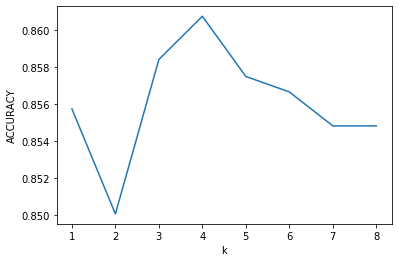

In [7]:
sns.lineplot(x="k", y="ACCURACY", data=df_scores)

Из графика видно, что при k = 4 точность выше. Поэтому для предсказания будем использовать k = 4.

Загружаем тестовый набор, для которого нужно построить предсказания.

In [8]:
new_test = pd.read_csv('jds101/new_test.csv')
new_test=new_test/255

Обучаем модель.

In [9]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, Ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

Строим прогноз.

In [12]:
pred = knn.predict(new_test)

Записываем полученный прогноз как датафрейм и добавляем к нему столбец id, который соответствеут индексу от 1 до 10000 включительно.

In [20]:
pred1 = pd.DataFrame(np.array(pred), columns=['label'],index=new_test.index)

In [21]:
pred1['id']=range(1,10001)
pred1

,label,id
0,1,1
1,8,2
2,3,3
3,6,4
4,1,5
...,...,...
9995,9,9996
9996,1,9997
9997,2,9998
9998,7,9999


Записываем в csv файл.

In [22]:
pred1.to_csv('pred1.csv', index=False)

Загружаем полученный файл в Kaggle. И получаем точность 0.86000.

### 2. Дерево решений, логрегрессия, наивный байес, метод опорных векторов

Пробуем применить другие классификаторы и сравнить их с KNN.

In [23]:
names = ['DecisionTreeClassifier', 'LogisticRegression','GaussianNB', 'BernoulliNB', 'SVC', 'KNN']

clf_list = [DecisionTreeClassifier(max_depth=10, ccp_alpha = 0.005),
            LogisticRegression(C=0.1),
            GaussianNB(),
            BernoulliNB(alpha=0.01),
            SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001),
            KNeighborsClassifier(n_neighbors=4)
           ]

In [24]:
for name, clf in zip(names, clf_list):
        t0 = datetime.now()
        clf.fit(Xtrain, Ytrain)
        print(name, end=': ')
        print(clf.score(Xtest, Ytest), "Time:", (datetime.now() - t0))

DecisionTreeClassifier: 0.7223333333333334 Time: 0:00:20.329753


C:\Users\darkj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.857 Time: 0:00:11.507075
GaussianNB: 0.6066666666666667 Time: 0:00:02.385596
BernoulliNB: 0.7153333333333334 Time: 0:00:00.660107
SVC: 0.8610833333333333 Time: 0:08:14.441011
KNN: 0.857 Time: 0:11:25.510316


Видим, что логистическая регрессия и метод опорных векторов дают неплохие результаты.
Также я вывела время за которое каждый из методов обучается.

Пробуем строить прогноз с помощью логрегресии и SVC.

In [25]:
pred_logreg = clf_list[1].predict(new_test)

pred_logreg = pd.DataFrame(np.array(pred_logreg), columns=['label'])

pred_logreg['id']=range(1,10001)

pred_logreg.to_csv('pred.csv', index=False)

In [26]:
pred_svc = clf_list[4].predict(new_test)

pred_svc= pd.DataFrame(np.array(pred_svc), columns=['label'])

pred_svc['id']=range(1,10001)

pred_svc.to_csv('pred.csv', index=False)

Эти прогнозы выдают в Kaggle точность 0.86133 и 0.87066 соответственно.

### 3. Снижение размерности (PCA)

Снизим размерность пространства с помощью PCA.

In [27]:
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X))

Посмотрим на первые 155 кумулятивных дисперсий.

In [30]:
(X_pca.var()/X_pca.var().sum()).cumsum().head(155)

0      0.290114
1      0.467390
2      0.527617
3      0.577320
4      0.615713
         ...   
150    0.937895
151    0.938280
152    0.938661
153    0.939040
154    0.939415
Length: 155, dtype: float64

Видим, что первые 155 компонент объясняют почти 95% данных. Поэтому оставляем только 155 признаков.

In [73]:
X_pca = pca.transform(X)[:,:155]
X_pca.shape

(60000, 155)

Разбиваем X_pca на трейн и тест сеты. И применяем SVC.

In [33]:
Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

In [34]:
svc = SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001)
svc.fit(Xtrain_pca, Ytrain_pca)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
print(svc.score(Xtest_pca, Ytest_pca))

0.858


Построим прогноз для new_test. Для этого для начала у него нужно тоже снизить размерность.

In [37]:
new_test_pca = pca.transform(new_test)[:,:155]

In [38]:
pred_pca = svc.predict(new_test_pca)

In [39]:
pred1_pca = pd.DataFrame(np.array(pred_pca), columns=['label'])

In [40]:
pred1_pca['id']=range(1,10001)

In [41]:
pred1_pca.to_csv('pred1_pca.csv', index=False)

Получаем точность 0.86833, что немного меньше, чем без применения PCA.

Попробуем применить KNN для X_pca. Проверим будет ли для данных со сниженной размерностью количество соседей k = 4 наилучшим.

In [42]:
cv_scores=[]
t0 = datetime.now()
for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_pca, Ytrain_pca)
    scores = knn.score(Xtest_pca,Ytest_pca)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'ACCURACY', 'STD'])
print("Time:", (datetime.now() - t0))

Time: 0:11:00.797225


,k,ACCURACY,STD
0,1,0.856000,0.0
1,2,0.852083,0.0
2,3,0.862000,0.0
3,4,0.863000,0.0
4,5,0.864083,0.0
5,6,0.865083,0.0
6,7,0.864500,0.0
7,8,0.865500,0.0
8,9,0.863000,0.0
9,10,0.863250,0.0


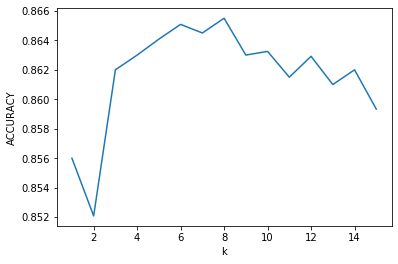

In [46]:
sns.lineplot(x="k", y="ACCURACY", data=df_scores)
df_scores

Видим, что здесь лучше выбирать k = 8.

In [44]:
pred_pca_knn8 = knn.predict(new_test_pca)

pred_pca_knn8 = pd.DataFrame(np.array(pred_pca_knn8), columns=['label'])

pred_pca_knn8['id']=range(1,10001)

pred_pca_knn8.to_csv('pred_pca_knn8.csv', index=False)

Получили результат 0.86433. Что немного лучше первоначального применения KNN без снижения размерности.

Попробуем изменить количество главных компонент и посмотрим какая будет точность на тестовой выборке. Будем менять количество компонент от 50 до 200 с шагом 50.

In [45]:
for n in range(50,250,50):
    X_pca = pca.transform(X)[:,:n]
    Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=8)
    knn.fit(Xtrain_pca, Ytrain_pca)
    print(n, "components" , end=': ')
    print(knn.score(Xtest_pca, Ytest_pca))

50 components: 0.8635833333333334
100 components: 0.8645833333333334
150 components: 0.8655833333333334
200 components: 0.8641666666666666


Для 150 компонент accuracy (0.8655833333333334) выше и с точностью до 4 знака совпадает с accuracy для 155 компонент (0.865500). Поэтому не будем строить прогноз для других размерностей.

### 4. RandomForest

Попробуем применить "случайный лес". Я пробовала применять разные параметры: изменяла критерий, максимальную глубину, ccp_alpha и количество деревьев (n_estimators). Приведенные ниже параметры, я посчитала оптимальными.

In [126]:
RF = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators = 300, random_state=0)

In [127]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
RF.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [128]:
RF.score(Xtest,Ytest)

0.8838333333333334

In [98]:
pred_RF = RF.predict(new_test)
pred_RF = pd.DataFrame(np.array(pred_RF), columns=['label'])

pred_RF['id']=range(1,10001)

pred_RF.to_csv('pred_RF.csv', index=False)

Для new_test получили точность 0.88533.

### 5. CatBoost

Пробуем CatBoost. Я изменяла количество итераций (500, 1000, 1500). Для 1500 точность получается выше. Увеличивать количество итераций я не стала, т.к. для 1500 вычисления занимают почти 1.5 часа.

In [47]:
cat = CatBoostClassifier(iterations = 1500)

In [155]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain, Ytrain)

Learning rate set to 0.068434
0:	learn: 2.0346992	total: 3.1s	remaining: 1h 17m 32s
1:	learn: 1.8489495	total: 6.18s	remaining: 1h 17m 10s
2:	learn: 1.7010860	total: 9.28s	remaining: 1h 17m 8s
3:	learn: 1.5890647	total: 12.3s	remaining: 1h 16m 55s
4:	learn: 1.4948560	total: 15.5s	remaining: 1h 17m 17s
5:	learn: 1.4147168	total: 18.6s	remaining: 1h 17m 20s
6:	learn: 1.3429199	total: 21.8s	remaining: 1h 17m 20s
7:	learn: 1.2789770	total: 24.9s	remaining: 1h 17m 16s
8:	learn: 1.2189065	total: 27.9s	remaining: 1h 17m 8s
9:	learn: 1.1693354	total: 31s	remaining: 1h 16m 57s
10:	learn: 1.1244262	total: 34.1s	remaining: 1h 16m 49s
11:	learn: 1.0823613	total: 37.1s	remaining: 1h 16m 43s
12:	learn: 1.0454652	total: 40.2s	remaining: 1h 16m 40s
13:	learn: 1.0100117	total: 43.5s	remaining: 1h 17m 1s
14:	learn: 0.9803764	total: 46.6s	remaining: 1h 16m 53s
15:	learn: 0.9492536	total: 49.7s	remaining: 1h 16m 52s
16:	learn: 0.9203142	total: 52.8s	remaining: 1h 16m 50s
17:	learn: 0.8957549	total: 56s	re

144:	learn: 0.3822831	total: 7m 36s	remaining: 1h 11m 2s
145:	learn: 0.3813250	total: 7m 39s	remaining: 1h 10m 59s
146:	learn: 0.3805518	total: 7m 42s	remaining: 1h 10m 56s
147:	learn: 0.3796483	total: 7m 45s	remaining: 1h 10m 53s
148:	learn: 0.3787006	total: 7m 48s	remaining: 1h 10m 49s
149:	learn: 0.3779484	total: 7m 51s	remaining: 1h 10m 45s
150:	learn: 0.3772453	total: 7m 54s	remaining: 1h 10m 42s
151:	learn: 0.3764229	total: 7m 57s	remaining: 1h 10m 38s
152:	learn: 0.3755302	total: 8m 1s	remaining: 1h 10m 35s
153:	learn: 0.3743891	total: 8m 4s	remaining: 1h 10m 31s
154:	learn: 0.3737179	total: 8m 7s	remaining: 1h 10m 27s
155:	learn: 0.3729135	total: 8m 10s	remaining: 1h 10m 24s
156:	learn: 0.3722334	total: 8m 13s	remaining: 1h 10m 20s
157:	learn: 0.3713216	total: 8m 16s	remaining: 1h 10m 17s
158:	learn: 0.3702396	total: 8m 19s	remaining: 1h 10m 13s
159:	learn: 0.3694758	total: 8m 22s	remaining: 1h 10m 10s
160:	learn: 0.3691482	total: 8m 25s	remaining: 1h 10m 6s
161:	learn: 0.36846

287:	learn: 0.3088121	total: 15m 3s	remaining: 1h 3m 23s
288:	learn: 0.3086510	total: 15m 7s	remaining: 1h 3m 20s
289:	learn: 0.3083039	total: 15m 10s	remaining: 1h 3m 17s
290:	learn: 0.3080710	total: 15m 13s	remaining: 1h 3m 14s
291:	learn: 0.3076835	total: 15m 16s	remaining: 1h 3m 10s
292:	learn: 0.3074191	total: 15m 19s	remaining: 1h 3m 7s
293:	learn: 0.3069626	total: 15m 22s	remaining: 1h 3m 4s
294:	learn: 0.3066939	total: 15m 25s	remaining: 1h 3m
295:	learn: 0.3060939	total: 15m 28s	remaining: 1h 2m 57s
296:	learn: 0.3054894	total: 15m 31s	remaining: 1h 2m 54s
297:	learn: 0.3049901	total: 15m 34s	remaining: 1h 2m 50s
298:	learn: 0.3045629	total: 15m 37s	remaining: 1h 2m 47s
299:	learn: 0.3044265	total: 15m 41s	remaining: 1h 2m 44s
300:	learn: 0.3040330	total: 15m 44s	remaining: 1h 2m 41s
301:	learn: 0.3034616	total: 15m 47s	remaining: 1h 2m 38s
302:	learn: 0.3028454	total: 15m 50s	remaining: 1h 2m 35s
303:	learn: 0.3025782	total: 15m 53s	remaining: 1h 2m 31s
304:	learn: 0.3023528	

434:	learn: 0.2723695	total: 22m 45s	remaining: 55m 42s
435:	learn: 0.2722329	total: 22m 48s	remaining: 55m 39s
436:	learn: 0.2720188	total: 22m 51s	remaining: 55m 36s
437:	learn: 0.2717151	total: 22m 54s	remaining: 55m 32s
438:	learn: 0.2715602	total: 22m 57s	remaining: 55m 29s
439:	learn: 0.2712815	total: 23m	remaining: 55m 26s
440:	learn: 0.2709975	total: 23m 3s	remaining: 55m 22s
441:	learn: 0.2706680	total: 23m 6s	remaining: 55m 19s
442:	learn: 0.2705367	total: 23m 10s	remaining: 55m 16s
443:	learn: 0.2701669	total: 23m 13s	remaining: 55m 13s
444:	learn: 0.2699705	total: 23m 16s	remaining: 55m 10s
445:	learn: 0.2696953	total: 23m 19s	remaining: 55m 7s
446:	learn: 0.2693085	total: 23m 22s	remaining: 55m 3s
447:	learn: 0.2692004	total: 23m 25s	remaining: 55m
448:	learn: 0.2689875	total: 23m 28s	remaining: 54m 57s
449:	learn: 0.2686200	total: 23m 31s	remaining: 54m 54s
450:	learn: 0.2683183	total: 23m 34s	remaining: 54m 50s
451:	learn: 0.2681147	total: 23m 37s	remaining: 54m 47s
452:

582:	learn: 0.2441244	total: 30m 25s	remaining: 47m 51s
583:	learn: 0.2440424	total: 30m 28s	remaining: 47m 48s
584:	learn: 0.2439516	total: 30m 31s	remaining: 47m 45s
585:	learn: 0.2438754	total: 30m 34s	remaining: 47m 42s
586:	learn: 0.2437793	total: 30m 38s	remaining: 47m 38s
587:	learn: 0.2436863	total: 30m 41s	remaining: 47m 35s
588:	learn: 0.2433962	total: 30m 44s	remaining: 47m 32s
589:	learn: 0.2432441	total: 30m 47s	remaining: 47m 29s
590:	learn: 0.2431361	total: 30m 50s	remaining: 47m 26s
591:	learn: 0.2430572	total: 30m 53s	remaining: 47m 22s
592:	learn: 0.2429380	total: 30m 56s	remaining: 47m 19s
593:	learn: 0.2427785	total: 30m 59s	remaining: 47m 16s
594:	learn: 0.2426364	total: 31m 2s	remaining: 47m 13s
595:	learn: 0.2424426	total: 31m 5s	remaining: 47m 10s
596:	learn: 0.2422139	total: 31m 9s	remaining: 47m 7s
597:	learn: 0.2421049	total: 31m 12s	remaining: 47m 3s
598:	learn: 0.2419592	total: 31m 15s	remaining: 47m
599:	learn: 0.2418546	total: 31m 18s	remaining: 46m 57s
6

730:	learn: 0.2252707	total: 38m 6s	remaining: 40m 5s
731:	learn: 0.2251713	total: 38m 9s	remaining: 40m 1s
732:	learn: 0.2250973	total: 38m 12s	remaining: 39m 58s
733:	learn: 0.2250509	total: 38m 15s	remaining: 39m 55s
734:	learn: 0.2249316	total: 38m 18s	remaining: 39m 52s
735:	learn: 0.2248063	total: 38m 22s	remaining: 39m 49s
736:	learn: 0.2245993	total: 38m 25s	remaining: 39m 46s
737:	learn: 0.2244851	total: 38m 28s	remaining: 39m 43s
738:	learn: 0.2244377	total: 38m 31s	remaining: 39m 40s
739:	learn: 0.2242783	total: 38m 34s	remaining: 39m 36s
740:	learn: 0.2241118	total: 38m 37s	remaining: 39m 33s
741:	learn: 0.2239427	total: 38m 40s	remaining: 39m 30s
742:	learn: 0.2238155	total: 38m 43s	remaining: 39m 27s
743:	learn: 0.2236521	total: 38m 46s	remaining: 39m 24s
744:	learn: 0.2235856	total: 38m 49s	remaining: 39m 21s
745:	learn: 0.2235123	total: 38m 52s	remaining: 39m 17s
746:	learn: 0.2233689	total: 38m 55s	remaining: 39m 14s
747:	learn: 0.2233129	total: 38m 59s	remaining: 39m 

878:	learn: 0.2084924	total: 45m 44s	remaining: 32m 18s
879:	learn: 0.2084127	total: 45m 47s	remaining: 32m 15s
880:	learn: 0.2082960	total: 45m 50s	remaining: 32m 12s
881:	learn: 0.2081783	total: 45m 53s	remaining: 32m 9s
882:	learn: 0.2079373	total: 45m 56s	remaining: 32m 6s
883:	learn: 0.2077816	total: 45m 59s	remaining: 32m 3s
884:	learn: 0.2077405	total: 46m 2s	remaining: 31m 59s
885:	learn: 0.2077051	total: 46m 5s	remaining: 31m 56s
886:	learn: 0.2076545	total: 46m 8s	remaining: 31m 53s
887:	learn: 0.2075429	total: 46m 11s	remaining: 31m 50s
888:	learn: 0.2074707	total: 46m 15s	remaining: 31m 47s
889:	learn: 0.2072112	total: 46m 18s	remaining: 31m 44s
890:	learn: 0.2071409	total: 46m 21s	remaining: 31m 41s
891:	learn: 0.2070108	total: 46m 24s	remaining: 31m 37s
892:	learn: 0.2069194	total: 46m 27s	remaining: 31m 34s
893:	learn: 0.2067982	total: 46m 30s	remaining: 31m 31s
894:	learn: 0.2066399	total: 46m 33s	remaining: 31m 28s
895:	learn: 0.2066061	total: 46m 36s	remaining: 31m 25

1025:	learn: 0.1948078	total: 53m 19s	remaining: 24m 38s
1026:	learn: 0.1947658	total: 53m 23s	remaining: 24m 35s
1027:	learn: 0.1946613	total: 53m 26s	remaining: 24m 32s
1028:	learn: 0.1945869	total: 53m 29s	remaining: 24m 28s
1029:	learn: 0.1945043	total: 53m 32s	remaining: 24m 25s
1030:	learn: 0.1944903	total: 53m 35s	remaining: 24m 22s
1031:	learn: 0.1944316	total: 53m 38s	remaining: 24m 19s
1032:	learn: 0.1943575	total: 53m 41s	remaining: 24m 16s
1033:	learn: 0.1941974	total: 53m 44s	remaining: 24m 13s
1034:	learn: 0.1939910	total: 53m 47s	remaining: 24m 10s
1035:	learn: 0.1939198	total: 53m 50s	remaining: 24m 6s
1036:	learn: 0.1938860	total: 53m 53s	remaining: 24m 3s
1037:	learn: 0.1938157	total: 53m 56s	remaining: 24m
1038:	learn: 0.1937089	total: 53m 59s	remaining: 23m 57s
1039:	learn: 0.1936235	total: 54m 3s	remaining: 23m 54s
1040:	learn: 0.1934948	total: 54m 6s	remaining: 23m 51s
1041:	learn: 0.1934733	total: 54m 9s	remaining: 23m 48s
1042:	learn: 0.1933971	total: 54m 12s	re

1171:	learn: 0.1831520	total: 1h 49s	remaining: 17m 1s
1172:	learn: 0.1830932	total: 1h 52s	remaining: 16m 58s
1173:	learn: 0.1830595	total: 1h 55s	remaining: 16m 55s
1174:	learn: 0.1830216	total: 1h 58s	remaining: 16m 52s
1175:	learn: 0.1829185	total: 1h 1m 2s	remaining: 16m 48s
1176:	learn: 0.1828280	total: 1h 1m 5s	remaining: 16m 45s
1177:	learn: 0.1827862	total: 1h 1m 8s	remaining: 16m 42s
1178:	learn: 0.1827181	total: 1h 1m 11s	remaining: 16m 39s
1179:	learn: 0.1826716	total: 1h 1m 14s	remaining: 16m 36s
1180:	learn: 0.1826348	total: 1h 1m 17s	remaining: 16m 33s
1181:	learn: 0.1825725	total: 1h 1m 20s	remaining: 16m 30s
1182:	learn: 0.1825493	total: 1h 1m 23s	remaining: 16m 27s
1183:	learn: 0.1823150	total: 1h 1m 26s	remaining: 16m 23s
1184:	learn: 0.1822196	total: 1h 1m 29s	remaining: 16m 20s
1185:	learn: 0.1821490	total: 1h 1m 32s	remaining: 16m 17s
1186:	learn: 0.1819977	total: 1h 1m 35s	remaining: 16m 14s
1187:	learn: 0.1818726	total: 1h 1m 38s	remaining: 16m 11s
1188:	learn: 

1312:	learn: 0.1727152	total: 1h 8m 8s	remaining: 9m 42s
1313:	learn: 0.1726205	total: 1h 8m 11s	remaining: 9m 39s
1314:	learn: 0.1725183	total: 1h 8m 14s	remaining: 9m 36s
1315:	learn: 0.1724833	total: 1h 8m 17s	remaining: 9m 32s
1316:	learn: 0.1723735	total: 1h 8m 20s	remaining: 9m 29s
1317:	learn: 0.1723166	total: 1h 8m 23s	remaining: 9m 26s
1318:	learn: 0.1722887	total: 1h 8m 26s	remaining: 9m 23s
1319:	learn: 0.1721803	total: 1h 8m 29s	remaining: 9m 20s
1320:	learn: 0.1721557	total: 1h 8m 33s	remaining: 9m 17s
1321:	learn: 0.1721109	total: 1h 8m 36s	remaining: 9m 14s
1322:	learn: 0.1720304	total: 1h 8m 39s	remaining: 9m 11s
1323:	learn: 0.1719313	total: 1h 8m 42s	remaining: 9m 7s
1324:	learn: 0.1718658	total: 1h 8m 45s	remaining: 9m 4s
1325:	learn: 0.1717839	total: 1h 8m 48s	remaining: 9m 1s
1326:	learn: 0.1717599	total: 1h 8m 51s	remaining: 8m 58s
1327:	learn: 0.1717294	total: 1h 8m 54s	remaining: 8m 55s
1328:	learn: 0.1716870	total: 1h 8m 57s	remaining: 8m 52s
1329:	learn: 0.171

1453:	learn: 0.1636068	total: 1h 15m 28s	remaining: 2m 23s
1454:	learn: 0.1634711	total: 1h 15m 31s	remaining: 2m 20s
1455:	learn: 0.1634330	total: 1h 15m 34s	remaining: 2m 17s
1456:	learn: 0.1633355	total: 1h 15m 38s	remaining: 2m 13s
1457:	learn: 0.1632503	total: 1h 15m 41s	remaining: 2m 10s
1458:	learn: 0.1632261	total: 1h 15m 44s	remaining: 2m 7s
1459:	learn: 0.1631648	total: 1h 15m 47s	remaining: 2m 4s
1460:	learn: 0.1631441	total: 1h 15m 50s	remaining: 2m 1s
1461:	learn: 0.1630841	total: 1h 15m 53s	remaining: 1m 58s
1462:	learn: 0.1629795	total: 1h 15m 56s	remaining: 1m 55s
1463:	learn: 0.1629376	total: 1h 15m 59s	remaining: 1m 52s
1464:	learn: 0.1628419	total: 1h 16m 2s	remaining: 1m 49s
1465:	learn: 0.1627791	total: 1h 16m 5s	remaining: 1m 45s
1466:	learn: 0.1627318	total: 1h 16m 9s	remaining: 1m 42s
1467:	learn: 0.1626381	total: 1h 16m 12s	remaining: 1m 39s
1468:	learn: 0.1626023	total: 1h 16m 15s	remaining: 1m 36s
1469:	learn: 0.1625374	total: 1h 16m 18s	remaining: 1m 33s
147

In [156]:
cat.score(Xtest,Ytest)

0.8988333333333334

In [157]:
pred_cat = cat.predict(new_test)
pred_cat = pd.DataFrame(np.array(pred_cat), columns=['label'])

pred_cat['id']=range(1,10001)

pred_cat.to_csv('pred_cat.csv', index=False)

Получили точность для new_test 0.90900. И это наилучший результат.

Применим CatBoost с PCA.

In [48]:
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain1, Ytrain1)

Learning rate set to 0.068434
0:	learn: 2.0679537	total: 743ms	remaining: 18m 33s
1:	learn: 1.8946509	total: 1.48s	remaining: 18m 25s
2:	learn: 1.7637615	total: 2.19s	remaining: 18m 15s
3:	learn: 1.6683770	total: 3.04s	remaining: 18m 57s
4:	learn: 1.5707910	total: 3.75s	remaining: 18m 41s
5:	learn: 1.4972349	total: 4.46s	remaining: 18m 30s
6:	learn: 1.4333444	total: 5.17s	remaining: 18m 22s
7:	learn: 1.3776403	total: 5.95s	remaining: 18m 30s
8:	learn: 1.3265000	total: 6.68s	remaining: 18m 27s
9:	learn: 1.2805997	total: 7.46s	remaining: 18m 31s
10:	learn: 1.2364084	total: 8.17s	remaining: 18m 25s
11:	learn: 1.1951583	total: 8.88s	remaining: 18m 21s
12:	learn: 1.1604033	total: 9.6s	remaining: 18m 17s
13:	learn: 1.1264376	total: 10.3s	remaining: 18m 13s
14:	learn: 1.0975418	total: 11s	remaining: 18m 10s
15:	learn: 1.0719518	total: 11.8s	remaining: 18m 16s
16:	learn: 1.0443806	total: 12.7s	remaining: 18m 32s
17:	learn: 1.0154597	total: 13.5s	remaining: 18m 34s
18:	learn: 0.9930223	total: 1

153:	learn: 0.4242254	total: 1m 52s	remaining: 16m 20s
154:	learn: 0.4230252	total: 1m 52s	remaining: 16m 18s
155:	learn: 0.4219361	total: 1m 53s	remaining: 16m 17s
156:	learn: 0.4211461	total: 1m 54s	remaining: 16m 16s
157:	learn: 0.4205241	total: 1m 54s	remaining: 16m 15s
158:	learn: 0.4194766	total: 1m 55s	remaining: 16m 14s
159:	learn: 0.4186179	total: 1m 56s	remaining: 16m 13s
160:	learn: 0.4177944	total: 1m 56s	remaining: 16m 12s
161:	learn: 0.4164586	total: 1m 57s	remaining: 16m 11s
162:	learn: 0.4155588	total: 1m 58s	remaining: 16m 10s
163:	learn: 0.4145163	total: 1m 58s	remaining: 16m 9s
164:	learn: 0.4136039	total: 1m 59s	remaining: 16m 8s
165:	learn: 0.4129392	total: 2m	remaining: 16m 7s
166:	learn: 0.4117416	total: 2m 1s	remaining: 16m 6s
167:	learn: 0.4112564	total: 2m 1s	remaining: 16m 5s
168:	learn: 0.4104758	total: 2m 2s	remaining: 16m 4s
169:	learn: 0.4095994	total: 2m 3s	remaining: 16m 3s
170:	learn: 0.4090802	total: 2m 3s	remaining: 16m 1s
171:	learn: 0.4081731	total

304:	learn: 0.3336194	total: 3m 35s	remaining: 14m 5s
305:	learn: 0.3331708	total: 3m 36s	remaining: 14m 4s
306:	learn: 0.3328069	total: 3m 37s	remaining: 14m 3s
307:	learn: 0.3324547	total: 3m 37s	remaining: 14m 3s
308:	learn: 0.3319509	total: 3m 38s	remaining: 14m 2s
309:	learn: 0.3312778	total: 3m 39s	remaining: 14m 1s
310:	learn: 0.3309039	total: 3m 39s	remaining: 14m
311:	learn: 0.3303563	total: 3m 40s	remaining: 13m 59s
312:	learn: 0.3301348	total: 3m 41s	remaining: 13m 59s
313:	learn: 0.3297355	total: 3m 41s	remaining: 13m 58s
314:	learn: 0.3294942	total: 3m 42s	remaining: 13m 57s
315:	learn: 0.3291771	total: 3m 43s	remaining: 13m 56s
316:	learn: 0.3290329	total: 3m 44s	remaining: 13m 56s
317:	learn: 0.3285109	total: 3m 44s	remaining: 13m 55s
318:	learn: 0.3282216	total: 3m 45s	remaining: 13m 54s
319:	learn: 0.3278437	total: 3m 46s	remaining: 13m 54s
320:	learn: 0.3274843	total: 3m 46s	remaining: 13m 53s
321:	learn: 0.3272690	total: 3m 47s	remaining: 13m 52s
322:	learn: 0.326793

455:	learn: 0.2880606	total: 5m 20s	remaining: 12m 14s
456:	learn: 0.2878008	total: 5m 21s	remaining: 12m 13s
457:	learn: 0.2874177	total: 5m 22s	remaining: 12m 12s
458:	learn: 0.2872256	total: 5m 22s	remaining: 12m 12s
459:	learn: 0.2869639	total: 5m 23s	remaining: 12m 11s
460:	learn: 0.2867811	total: 5m 24s	remaining: 12m 10s
461:	learn: 0.2865868	total: 5m 24s	remaining: 12m 9s
462:	learn: 0.2861792	total: 5m 25s	remaining: 12m 9s
463:	learn: 0.2859470	total: 5m 26s	remaining: 12m 8s
464:	learn: 0.2856961	total: 5m 26s	remaining: 12m 7s
465:	learn: 0.2855395	total: 5m 27s	remaining: 12m 6s
466:	learn: 0.2852548	total: 5m 28s	remaining: 12m 6s
467:	learn: 0.2848565	total: 5m 28s	remaining: 12m 5s
468:	learn: 0.2847297	total: 5m 29s	remaining: 12m 4s
469:	learn: 0.2845923	total: 5m 30s	remaining: 12m 3s
470:	learn: 0.2844111	total: 5m 30s	remaining: 12m 3s
471:	learn: 0.2841778	total: 5m 31s	remaining: 12m 2s
472:	learn: 0.2838696	total: 5m 32s	remaining: 12m 1s
473:	learn: 0.2836691	

606:	learn: 0.2557297	total: 7m 14s	remaining: 10m 39s
607:	learn: 0.2554232	total: 7m 15s	remaining: 10m 38s
608:	learn: 0.2553154	total: 7m 16s	remaining: 10m 37s
609:	learn: 0.2552106	total: 7m 17s	remaining: 10m 37s
610:	learn: 0.2550925	total: 7m 17s	remaining: 10m 36s
611:	learn: 0.2548564	total: 7m 18s	remaining: 10m 36s
612:	learn: 0.2546988	total: 7m 19s	remaining: 10m 35s
613:	learn: 0.2544918	total: 7m 19s	remaining: 10m 34s
614:	learn: 0.2543187	total: 7m 20s	remaining: 10m 34s
615:	learn: 0.2540803	total: 7m 21s	remaining: 10m 33s
616:	learn: 0.2539528	total: 7m 22s	remaining: 10m 32s
617:	learn: 0.2537461	total: 7m 22s	remaining: 10m 32s
618:	learn: 0.2535678	total: 7m 23s	remaining: 10m 31s
619:	learn: 0.2533081	total: 7m 24s	remaining: 10m 30s
620:	learn: 0.2531678	total: 7m 25s	remaining: 10m 30s
621:	learn: 0.2530219	total: 7m 25s	remaining: 10m 29s
622:	learn: 0.2527762	total: 7m 26s	remaining: 10m 28s
623:	learn: 0.2525658	total: 7m 27s	remaining: 10m 27s
624:	learn

759:	learn: 0.2289172	total: 9m 12s	remaining: 8m 57s
760:	learn: 0.2287889	total: 9m 13s	remaining: 8m 57s
761:	learn: 0.2286578	total: 9m 14s	remaining: 8m 56s
762:	learn: 0.2286024	total: 9m 15s	remaining: 8m 56s
763:	learn: 0.2283189	total: 9m 16s	remaining: 8m 55s
764:	learn: 0.2281960	total: 9m 16s	remaining: 8m 55s
765:	learn: 0.2280630	total: 9m 17s	remaining: 8m 54s
766:	learn: 0.2278970	total: 9m 18s	remaining: 8m 53s
767:	learn: 0.2277936	total: 9m 19s	remaining: 8m 53s
768:	learn: 0.2275960	total: 9m 20s	remaining: 8m 52s
769:	learn: 0.2274345	total: 9m 20s	remaining: 8m 51s
770:	learn: 0.2272998	total: 9m 21s	remaining: 8m 51s
771:	learn: 0.2271696	total: 9m 22s	remaining: 8m 50s
772:	learn: 0.2269614	total: 9m 23s	remaining: 8m 49s
773:	learn: 0.2268356	total: 9m 24s	remaining: 8m 49s
774:	learn: 0.2267427	total: 9m 24s	remaining: 8m 48s
775:	learn: 0.2265653	total: 9m 25s	remaining: 8m 47s
776:	learn: 0.2264261	total: 9m 26s	remaining: 8m 46s
777:	learn: 0.2263535	total:

911:	learn: 0.2074467	total: 11m 10s	remaining: 7m 12s
912:	learn: 0.2073472	total: 11m 11s	remaining: 7m 11s
913:	learn: 0.2071974	total: 11m 12s	remaining: 7m 10s
914:	learn: 0.2071421	total: 11m 12s	remaining: 7m 10s
915:	learn: 0.2069864	total: 11m 13s	remaining: 7m 9s
916:	learn: 0.2067943	total: 11m 14s	remaining: 7m 8s
917:	learn: 0.2067338	total: 11m 15s	remaining: 7m 8s
918:	learn: 0.2065598	total: 11m 16s	remaining: 7m 7s
919:	learn: 0.2064020	total: 11m 16s	remaining: 7m 6s
920:	learn: 0.2061749	total: 11m 17s	remaining: 7m 6s
921:	learn: 0.2060267	total: 11m 18s	remaining: 7m 5s
922:	learn: 0.2059055	total: 11m 19s	remaining: 7m 4s
923:	learn: 0.2056622	total: 11m 19s	remaining: 7m 3s
924:	learn: 0.2054689	total: 11m 20s	remaining: 7m 3s
925:	learn: 0.2053551	total: 11m 21s	remaining: 7m 2s
926:	learn: 0.2051959	total: 11m 22s	remaining: 7m 1s
927:	learn: 0.2050866	total: 11m 22s	remaining: 7m
928:	learn: 0.2049658	total: 11m 23s	remaining: 7m
929:	learn: 0.2048373	total: 1

1061:	learn: 0.1882556	total: 13m 7s	remaining: 5m 24s
1062:	learn: 0.1881308	total: 13m 7s	remaining: 5m 23s
1063:	learn: 0.1880782	total: 13m 8s	remaining: 5m 23s
1064:	learn: 0.1879844	total: 13m 9s	remaining: 5m 22s
1065:	learn: 0.1878963	total: 13m 10s	remaining: 5m 21s
1066:	learn: 0.1877956	total: 13m 10s	remaining: 5m 20s
1067:	learn: 0.1876903	total: 13m 11s	remaining: 5m 20s
1068:	learn: 0.1876407	total: 13m 12s	remaining: 5m 19s
1069:	learn: 0.1874945	total: 13m 12s	remaining: 5m 18s
1070:	learn: 0.1872879	total: 13m 13s	remaining: 5m 17s
1071:	learn: 0.1871292	total: 13m 14s	remaining: 5m 17s
1072:	learn: 0.1870197	total: 13m 14s	remaining: 5m 16s
1073:	learn: 0.1868400	total: 13m 15s	remaining: 5m 15s
1074:	learn: 0.1866987	total: 13m 16s	remaining: 5m 14s
1075:	learn: 0.1865637	total: 13m 17s	remaining: 5m 14s
1076:	learn: 0.1863388	total: 13m 18s	remaining: 5m 13s
1077:	learn: 0.1861298	total: 13m 19s	remaining: 5m 12s
1078:	learn: 0.1859086	total: 13m 20s	remaining: 5m 

1209:	learn: 0.1713341	total: 15m 6s	remaining: 3m 37s
1210:	learn: 0.1712307	total: 15m 7s	remaining: 3m 36s
1211:	learn: 0.1711687	total: 15m 8s	remaining: 3m 35s
1212:	learn: 0.1710295	total: 15m 9s	remaining: 3m 35s
1213:	learn: 0.1708908	total: 15m 9s	remaining: 3m 34s
1214:	learn: 0.1708460	total: 15m 10s	remaining: 3m 33s
1215:	learn: 0.1707798	total: 15m 11s	remaining: 3m 32s
1216:	learn: 0.1706834	total: 15m 11s	remaining: 3m 32s
1217:	learn: 0.1706063	total: 15m 12s	remaining: 3m 31s
1218:	learn: 0.1705599	total: 15m 13s	remaining: 3m 30s
1219:	learn: 0.1704657	total: 15m 14s	remaining: 3m 29s
1220:	learn: 0.1703887	total: 15m 15s	remaining: 3m 29s
1221:	learn: 0.1703131	total: 15m 15s	remaining: 3m 28s
1222:	learn: 0.1701993	total: 15m 16s	remaining: 3m 27s
1223:	learn: 0.1700353	total: 15m 17s	remaining: 3m 26s
1224:	learn: 0.1699771	total: 15m 17s	remaining: 3m 26s
1225:	learn: 0.1699193	total: 15m 18s	remaining: 3m 25s
1226:	learn: 0.1698174	total: 15m 19s	remaining: 3m 2

1357:	learn: 0.1563946	total: 17m 1s	remaining: 1m 46s
1358:	learn: 0.1563339	total: 17m 2s	remaining: 1m 46s
1359:	learn: 0.1562605	total: 17m 3s	remaining: 1m 45s
1360:	learn: 0.1562097	total: 17m 4s	remaining: 1m 44s
1361:	learn: 0.1561030	total: 17m 4s	remaining: 1m 43s
1362:	learn: 0.1560208	total: 17m 5s	remaining: 1m 43s
1363:	learn: 0.1559177	total: 17m 6s	remaining: 1m 42s
1364:	learn: 0.1558930	total: 17m 7s	remaining: 1m 41s
1365:	learn: 0.1557726	total: 17m 8s	remaining: 1m 40s
1366:	learn: 0.1557127	total: 17m 9s	remaining: 1m 40s
1367:	learn: 0.1556844	total: 17m 9s	remaining: 1m 39s
1368:	learn: 0.1555140	total: 17m 10s	remaining: 1m 38s
1369:	learn: 0.1554206	total: 17m 11s	remaining: 1m 37s
1370:	learn: 0.1553251	total: 17m 12s	remaining: 1m 37s
1371:	learn: 0.1552769	total: 17m 13s	remaining: 1m 36s
1372:	learn: 0.1552420	total: 17m 13s	remaining: 1m 35s
1373:	learn: 0.1551559	total: 17m 14s	remaining: 1m 34s
1374:	learn: 0.1549873	total: 17m 15s	remaining: 1m 34s
137

In [49]:
cat.score(Xtest1,Ytest1)

0.8864166666666666

Accuracy получилась ниже, чем без применения PCA. Поэтому не будем делать прогноз.

### 6. Снижение размерности (t-SNE)

Применим t-SNE.

In [50]:
X_tsne = TSNE(random_state=42).fit_transform(X)
X_tsne.shape   

(60000, 2)

Визуализируем полученный результат.

In [68]:
import matplotlib.patheffects as PathEffects
def scatter(x, colors):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(classes[i]), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(9.982557, 7.182563, 'T-shirt/top'),
  Text(35.211304, 26.47134, 'Trouser'),
  Text(-32.896416, 5.086321, 'Pullover'),
  Text(2.5122082, 35.505573, 'Dress'),
  Text(-29.994047, 17.383904, 'Coat'),
  Text(18.708443, -16.584656, 'Sandal'),
  Text(-16.443384, 7.231048, 'Shirt'),
  Text(38.189346, -17.533527, 'Sneaker'),
  Text(-22.299942, -24.515429, 'Bag'),
  Text(1.9103718, -42.378136, 'Ankle boot')])

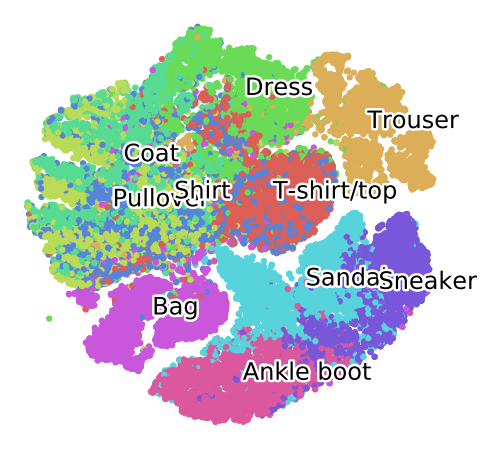

In [69]:
scatter(X_tsne, Y)

Из графика видим, что брюки и сумки хорошо отделяются от остальных классов.

Применим к нему CatBoost.

In [53]:
Xtrain_tsne, Xtest_tsne, Ytrain_tsne, Ytest_tsne = train_test_split(X_tsne, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain_tsne, Ytrain_tsne)

Learning rate set to 0.068434
0:	learn: 2.0279239	total: 40.1ms	remaining: 1m
1:	learn: 1.8405964	total: 70.1ms	remaining: 52.5s
2:	learn: 1.7058230	total: 99.6ms	remaining: 49.7s
3:	learn: 1.5946238	total: 129ms	remaining: 48.3s
4:	learn: 1.5077510	total: 159ms	remaining: 47.4s
5:	learn: 1.4305525	total: 189ms	remaining: 47.1s
6:	learn: 1.3628503	total: 225ms	remaining: 47.9s
7:	learn: 1.3051183	total: 254ms	remaining: 47.4s
8:	learn: 1.2544272	total: 284ms	remaining: 47s
9:	learn: 1.2077015	total: 313ms	remaining: 46.7s
10:	learn: 1.1649183	total: 343ms	remaining: 46.4s
11:	learn: 1.1270717	total: 372ms	remaining: 46.1s
12:	learn: 1.0942429	total: 408ms	remaining: 46.7s
13:	learn: 1.0616643	total: 438ms	remaining: 46.5s
14:	learn: 1.0342217	total: 468ms	remaining: 46.3s
15:	learn: 1.0073657	total: 499ms	remaining: 46.3s
16:	learn: 0.9828535	total: 528ms	remaining: 46.1s
17:	learn: 0.9616695	total: 558ms	remaining: 45.9s
18:	learn: 0.9413676	total: 593ms	remaining: 46.2s
19:	learn: 0.

164:	learn: 0.5696361	total: 5.44s	remaining: 44s
165:	learn: 0.5693104	total: 5.48s	remaining: 44s
166:	learn: 0.5689130	total: 5.51s	remaining: 44s
167:	learn: 0.5685350	total: 5.54s	remaining: 43.9s
168:	learn: 0.5680683	total: 5.57s	remaining: 43.9s
169:	learn: 0.5677352	total: 5.61s	remaining: 43.9s
170:	learn: 0.5673172	total: 5.64s	remaining: 43.9s
171:	learn: 0.5669645	total: 5.68s	remaining: 43.8s
172:	learn: 0.5665960	total: 5.71s	remaining: 43.8s
173:	learn: 0.5663462	total: 5.74s	remaining: 43.8s
174:	learn: 0.5659615	total: 5.77s	remaining: 43.7s
175:	learn: 0.5656477	total: 5.81s	remaining: 43.7s
176:	learn: 0.5652326	total: 5.85s	remaining: 43.7s
177:	learn: 0.5649906	total: 5.89s	remaining: 43.8s
178:	learn: 0.5644957	total: 5.94s	remaining: 43.8s
179:	learn: 0.5641862	total: 5.99s	remaining: 43.9s
180:	learn: 0.5638282	total: 6.03s	remaining: 44s
181:	learn: 0.5634457	total: 6.07s	remaining: 44s
182:	learn: 0.5630798	total: 6.11s	remaining: 43.9s
183:	learn: 0.5628722	

324:	learn: 0.5303115	total: 10.9s	remaining: 39.4s
325:	learn: 0.5301197	total: 10.9s	remaining: 39.4s
326:	learn: 0.5299320	total: 11s	remaining: 39.4s
327:	learn: 0.5297387	total: 11s	remaining: 39.3s
328:	learn: 0.5296186	total: 11s	remaining: 39.3s
329:	learn: 0.5295073	total: 11.1s	remaining: 39.2s
330:	learn: 0.5294341	total: 11.1s	remaining: 39.2s
331:	learn: 0.5293237	total: 11.1s	remaining: 39.2s
332:	learn: 0.5292612	total: 11.2s	remaining: 39.2s
333:	learn: 0.5287635	total: 11.2s	remaining: 39.2s
334:	learn: 0.5286760	total: 11.3s	remaining: 39.1s
335:	learn: 0.5283286	total: 11.3s	remaining: 39.1s
336:	learn: 0.5281642	total: 11.3s	remaining: 39.1s
337:	learn: 0.5280196	total: 11.4s	remaining: 39.1s
338:	learn: 0.5278564	total: 11.4s	remaining: 39s
339:	learn: 0.5276267	total: 11.4s	remaining: 39s
340:	learn: 0.5275232	total: 11.5s	remaining: 39s
341:	learn: 0.5274182	total: 11.5s	remaining: 39s
342:	learn: 0.5273338	total: 11.5s	remaining: 38.9s
343:	learn: 0.5271938	tota

488:	learn: 0.5091865	total: 17.1s	remaining: 35.4s
489:	learn: 0.5091312	total: 17.2s	remaining: 35.4s
490:	learn: 0.5090370	total: 17.2s	remaining: 35.3s
491:	learn: 0.5089545	total: 17.2s	remaining: 35.3s
492:	learn: 0.5089336	total: 17.3s	remaining: 35.2s
493:	learn: 0.5088731	total: 17.3s	remaining: 35.3s
494:	learn: 0.5088211	total: 17.4s	remaining: 35.3s
495:	learn: 0.5087648	total: 17.4s	remaining: 35.2s
496:	learn: 0.5086771	total: 17.4s	remaining: 35.2s
497:	learn: 0.5086232	total: 17.5s	remaining: 35.2s
498:	learn: 0.5083875	total: 17.5s	remaining: 35.1s
499:	learn: 0.5083104	total: 17.6s	remaining: 35.1s
500:	learn: 0.5081038	total: 17.6s	remaining: 35.1s
501:	learn: 0.5080150	total: 17.6s	remaining: 35s
502:	learn: 0.5079788	total: 17.7s	remaining: 35s
503:	learn: 0.5078547	total: 17.7s	remaining: 35s
504:	learn: 0.5077776	total: 17.7s	remaining: 34.9s
505:	learn: 0.5076126	total: 17.8s	remaining: 34.9s
506:	learn: 0.5075328	total: 17.8s	remaining: 34.8s
507:	learn: 0.5074

652:	learn: 0.4951239	total: 22.9s	remaining: 29.7s
653:	learn: 0.4950731	total: 22.9s	remaining: 29.6s
654:	learn: 0.4950380	total: 22.9s	remaining: 29.6s
655:	learn: 0.4949845	total: 23s	remaining: 29.6s
656:	learn: 0.4949010	total: 23s	remaining: 29.5s
657:	learn: 0.4948711	total: 23s	remaining: 29.5s
658:	learn: 0.4948545	total: 23.1s	remaining: 29.4s
659:	learn: 0.4948268	total: 23.1s	remaining: 29.4s
660:	learn: 0.4947776	total: 23.1s	remaining: 29.4s
661:	learn: 0.4946568	total: 23.2s	remaining: 29.3s
662:	learn: 0.4946092	total: 23.2s	remaining: 29.3s
663:	learn: 0.4944919	total: 23.2s	remaining: 29.2s
664:	learn: 0.4944457	total: 23.3s	remaining: 29.2s
665:	learn: 0.4944268	total: 23.3s	remaining: 29.2s
666:	learn: 0.4943164	total: 23.3s	remaining: 29.1s
667:	learn: 0.4942447	total: 23.4s	remaining: 29.1s
668:	learn: 0.4941827	total: 23.4s	remaining: 29.1s
669:	learn: 0.4939569	total: 23.4s	remaining: 29s
670:	learn: 0.4939127	total: 23.5s	remaining: 29s
671:	learn: 0.4938812	

812:	learn: 0.4842357	total: 28.3s	remaining: 24s
813:	learn: 0.4841487	total: 28.4s	remaining: 23.9s
814:	learn: 0.4840975	total: 28.4s	remaining: 23.9s
815:	learn: 0.4840587	total: 28.5s	remaining: 23.9s
816:	learn: 0.4840311	total: 28.5s	remaining: 23.8s
817:	learn: 0.4840052	total: 28.5s	remaining: 23.8s
818:	learn: 0.4839596	total: 28.6s	remaining: 23.8s
819:	learn: 0.4839386	total: 28.6s	remaining: 23.7s
820:	learn: 0.4838614	total: 28.6s	remaining: 23.7s
821:	learn: 0.4838190	total: 28.7s	remaining: 23.7s
822:	learn: 0.4837286	total: 28.7s	remaining: 23.6s
823:	learn: 0.4837015	total: 28.7s	remaining: 23.6s
824:	learn: 0.4836280	total: 28.8s	remaining: 23.5s
825:	learn: 0.4835495	total: 28.8s	remaining: 23.5s
826:	learn: 0.4835296	total: 28.8s	remaining: 23.5s
827:	learn: 0.4834834	total: 28.9s	remaining: 23.4s
828:	learn: 0.4834075	total: 28.9s	remaining: 23.4s
829:	learn: 0.4833698	total: 28.9s	remaining: 23.3s
830:	learn: 0.4833311	total: 29s	remaining: 23.3s
831:	learn: 0.48

972:	learn: 0.4760998	total: 33.5s	remaining: 18.1s
973:	learn: 0.4760758	total: 33.5s	remaining: 18.1s
974:	learn: 0.4760567	total: 33.5s	remaining: 18.1s
975:	learn: 0.4760321	total: 33.6s	remaining: 18s
976:	learn: 0.4759899	total: 33.6s	remaining: 18s
977:	learn: 0.4759738	total: 33.6s	remaining: 18s
978:	learn: 0.4758704	total: 33.7s	remaining: 17.9s
979:	learn: 0.4758132	total: 33.7s	remaining: 17.9s
980:	learn: 0.4757560	total: 33.8s	remaining: 17.9s
981:	learn: 0.4757092	total: 33.8s	remaining: 17.8s
982:	learn: 0.4756403	total: 33.8s	remaining: 17.8s
983:	learn: 0.4754898	total: 33.9s	remaining: 17.8s
984:	learn: 0.4754712	total: 33.9s	remaining: 17.7s
985:	learn: 0.4754266	total: 34s	remaining: 17.7s
986:	learn: 0.4753744	total: 34s	remaining: 17.7s
987:	learn: 0.4753520	total: 34s	remaining: 17.6s
988:	learn: 0.4753297	total: 34.1s	remaining: 17.6s
989:	learn: 0.4753076	total: 34.1s	remaining: 17.6s
990:	learn: 0.4752934	total: 34.1s	remaining: 17.5s
991:	learn: 0.4752418	to

1132:	learn: 0.4688265	total: 39.2s	remaining: 12.7s
1133:	learn: 0.4687802	total: 39.3s	remaining: 12.7s
1134:	learn: 0.4687428	total: 39.3s	remaining: 12.6s
1135:	learn: 0.4687002	total: 39.4s	remaining: 12.6s
1136:	learn: 0.4686523	total: 39.4s	remaining: 12.6s
1137:	learn: 0.4686400	total: 39.5s	remaining: 12.6s
1138:	learn: 0.4686225	total: 39.5s	remaining: 12.5s
1139:	learn: 0.4686097	total: 39.5s	remaining: 12.5s
1140:	learn: 0.4685881	total: 39.6s	remaining: 12.5s
1141:	learn: 0.4685745	total: 39.6s	remaining: 12.4s
1142:	learn: 0.4685335	total: 39.7s	remaining: 12.4s
1143:	learn: 0.4684894	total: 39.7s	remaining: 12.4s
1144:	learn: 0.4684323	total: 39.7s	remaining: 12.3s
1145:	learn: 0.4683883	total: 39.8s	remaining: 12.3s
1146:	learn: 0.4683640	total: 39.8s	remaining: 12.2s
1147:	learn: 0.4683333	total: 39.8s	remaining: 12.2s
1148:	learn: 0.4682949	total: 39.9s	remaining: 12.2s
1149:	learn: 0.4682239	total: 39.9s	remaining: 12.1s
1150:	learn: 0.4681955	total: 39.9s	remaining:

1291:	learn: 0.4624178	total: 45.3s	remaining: 7.29s
1292:	learn: 0.4623721	total: 45.3s	remaining: 7.25s
1293:	learn: 0.4623519	total: 45.3s	remaining: 7.22s
1294:	learn: 0.4623427	total: 45.4s	remaining: 7.18s
1295:	learn: 0.4623146	total: 45.4s	remaining: 7.15s
1296:	learn: 0.4622978	total: 45.4s	remaining: 7.11s
1297:	learn: 0.4622647	total: 45.5s	remaining: 7.08s
1298:	learn: 0.4622571	total: 45.5s	remaining: 7.04s
1299:	learn: 0.4622437	total: 45.6s	remaining: 7.01s
1300:	learn: 0.4622151	total: 45.6s	remaining: 6.98s
1301:	learn: 0.4621987	total: 45.7s	remaining: 6.94s
1302:	learn: 0.4621713	total: 45.7s	remaining: 6.91s
1303:	learn: 0.4620977	total: 45.7s	remaining: 6.87s
1304:	learn: 0.4620131	total: 45.7s	remaining: 6.83s
1305:	learn: 0.4619815	total: 45.8s	remaining: 6.8s
1306:	learn: 0.4619509	total: 45.8s	remaining: 6.77s
1307:	learn: 0.4619144	total: 45.9s	remaining: 6.73s
1308:	learn: 0.4619034	total: 45.9s	remaining: 6.7s
1309:	learn: 0.4618751	total: 45.9s	remaining: 6

1449:	learn: 0.4570037	total: 50.7s	remaining: 1.75s
1450:	learn: 0.4569760	total: 50.7s	remaining: 1.71s
1451:	learn: 0.4569489	total: 50.7s	remaining: 1.68s
1452:	learn: 0.4569226	total: 50.8s	remaining: 1.64s
1453:	learn: 0.4568425	total: 50.8s	remaining: 1.61s
1454:	learn: 0.4568290	total: 50.8s	remaining: 1.57s
1455:	learn: 0.4568074	total: 50.9s	remaining: 1.54s
1456:	learn: 0.4567919	total: 50.9s	remaining: 1.5s
1457:	learn: 0.4567641	total: 51s	remaining: 1.47s
1458:	learn: 0.4567458	total: 51s	remaining: 1.43s
1459:	learn: 0.4567056	total: 51s	remaining: 1.4s
1460:	learn: 0.4566754	total: 51.1s	remaining: 1.36s
1461:	learn: 0.4566240	total: 51.1s	remaining: 1.33s
1462:	learn: 0.4566084	total: 51.1s	remaining: 1.29s
1463:	learn: 0.4565608	total: 51.1s	remaining: 1.26s
1464:	learn: 0.4565008	total: 51.2s	remaining: 1.22s
1465:	learn: 0.4564206	total: 51.2s	remaining: 1.19s
1466:	learn: 0.4563831	total: 51.3s	remaining: 1.15s
1467:	learn: 0.4563578	total: 51.3s	remaining: 1.12s
1

In [55]:
cat.score(Xtest_tsne,Ytest_tsne)

0.8236666666666667

Результат на тестовой выборке получился ниже, поэтому не будем его использовать.

Дальше я применяла t-SNE к X_pca, т.е. к данным со сниженной размерностью до 155 компонент с помощью PCA.

In [57]:
X_pca_tsne = TSNE(random_state=42).fit_transform(X_pca)
X_pca_tsne.shape  

(60000, 2)

(<Figure size 576x576 with 1 Axes>,
 [Text(9.276054, 9.64506, 'T-shirt/top'),
  Text(35.920284, 25.836388, 'Trouser'),
  Text(-29.856365, 3.9017577, 'Pullover'),
  Text(2.1616552, 38.62009, 'Dress'),
  Text(-31.7602, 17.047237, 'Coat'),
  Text(15.430542, -21.8827, 'Sandal'),
  Text(-16.362684, 7.884285, 'Shirt'),
  Text(38.384785, -17.128414, 'Sneaker'),
  Text(-21.28092, -22.581688, 'Bag'),
  Text(2.59102, -43.502003, 'Ankle boot')])

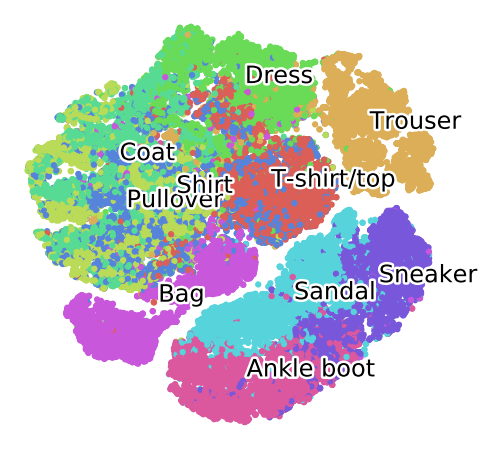

In [70]:
scatter(X_pca_tsne, Y)

График несильно отличается от предыдущего. Но при этом вычисления происходят быстрее. Без PCA у меня вычисления заняли больше часа. Если же предварительно уменьшить размерность с помощью PCA до 155 компонент, то вычисления занимают минут 20.

Сравним t-SNE с PCA. Для этого выделим 2 главные компоненты и посторим график.

In [72]:
X_pca2 = pca.transform(X)[:,:2]
X_pca2.shape

(60000, 2)

(<Figure size 576x576 with 1 Axes>,
 [Text(3.244728467044433, -2.717997996080818, 'T-shirt/top'),
  Text(0.09118882546510704, -5.595244184951341, 'Trouser'),
  Text(4.16219960451158, 1.4283481779467577, 'Pullover'),
  Text(1.2233546815286884, -4.367045715632692, 'Dress'),
  Text(4.870581051552331, 1.1507188161671884, 'Coat'),
  Text(-6.230273467339888, 0.28054742081768125, 'Sandal'),
  Text(2.627800677972143, -0.22420471668083777, 'Shirt'),
  Text(-5.967099861809021, 1.3632411082869926, 'Sneaker'),
  Text(0.1424416178230545, 3.866539488556583, 'Bag'),
  Text(-2.4783137588431936, 4.5333668513258445, 'Ankle boot')])

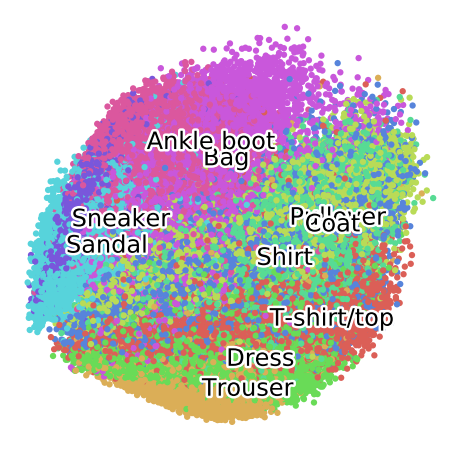

In [74]:
scatter(X_pca2, Y)

Очевидно, что PCA справился хуже t-SNE.

### 7. Подбор ccp_alpha для дерева решений

Еще я пыталась подобрать ccp_alpha для дерева решений, но там результат получается гораздо хуже. Чтобы вычисления прошли быстрее я обучала модель на 10% от всей исходной выборки.

In [4]:
Xsample, __, Ysample, __ = train_test_split(Xtrain, Ytrain, test_size=0.9, random_state=42)

In [5]:
Xsample.shape

(4800, 784)

In [6]:
Xsample_train, Xsample_test, Ysample_train, Ysample_test = train_test_split(Xsample, Ysample, test_size=0.2, random_state=42)

In [21]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(Xsample_train, Ysample_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [22]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(Xsample_train, Ysample_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07354698352269573


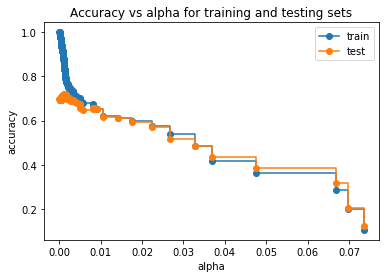

In [23]:
train_scores = [clf.score(Xsample_train, Ysample_train) for clf in clfs]
test_scores = [clf.score(Xsample_test, Ysample_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### 8. Выводы
Лучший результат показал CatBoost (0.90900 и 0.89728 в public и private лидербордах соответственно).

Снижение размерности не всегда улучшает результат. Для KNN применение PCA привело к небольшому улучшению точности. Для других же методов точность немного упала.

Метод t-SNE хорошо отделил классы брюки и сумки от других классов.

Использование t-SNE лучше проводить на предварительно сниженных размерностях с помощью PCA.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

Получим данные и сразу разобьем их на трейн и тест сеты, чтобы проводить кросс-валидацию.

In [4]:
def get_data(limit=None):
    df = pd.read_csv('jds101/fashion-mnist_train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

if __name__ == '__main__':
    X, Y = get_data(60000)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)



### 1. KNN

Попробуем применить KNN. Подберем количество соседей с наибольшим accuracy на тестовой выборке. Перебираем k от 1 до 8 включительно.

In [5]:
cv_scores=[]
for k in range(1,9):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain, Ytrain)
    scores = knn.score(Xtest,Ytest)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'ACCURACY', 'STD'])

Строим график accuracy тестовой выборки. По оси х откладываем количество соседей. По оси у - точность тестовой выборки.

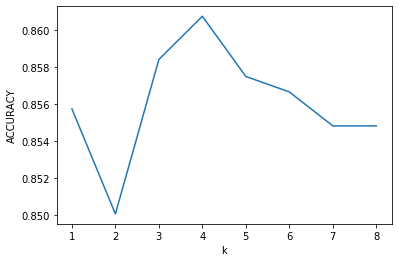

In [7]:
sns.lineplot(x="k", y="ACCURACY", data=df_scores)

Из графика видно, что при k = 4 точность выше. Поэтому для предсказания будем использовать k = 4.

Загружаем тестовый набор, для которого нужно построить предсказания.

In [8]:
new_test = pd.read_csv('jds101/new_test.csv')
new_test=new_test/255

Обучаем модель.

In [9]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, Ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

Строим прогноз.

In [12]:
pred = knn.predict(new_test)

Записываем полученный прогноз как датафрейм и добавляем к нему столбец id, который соответствеут индексу от 1 до 10000 включительно.

In [20]:
pred1 = pd.DataFrame(np.array(pred), columns=['label'],index=new_test.index)

In [21]:
pred1['id']=range(1,10001)
pred1

,label,id
0,1,1
1,8,2
2,3,3
3,6,4
4,1,5
...,...,...
9995,9,9996
9996,1,9997
9997,2,9998
9998,7,9999


Записываем в csv файл.

In [22]:
pred1.to_csv('pred1.csv', index=False)

Загружаем полученный файл в Kaggle. И получаем точность 0.86000.

### 2. Дерево решений, логрегрессия, наивный байес, метод опорных векторов

Пробуем применить другие классификаторы и сравнить их с KNN.

In [23]:
names = ['DecisionTreeClassifier', 'LogisticRegression','GaussianNB', 'BernoulliNB', 'SVC', 'KNN']

clf_list = [DecisionTreeClassifier(max_depth=10, ccp_alpha = 0.005),
            LogisticRegression(C=0.1),
            GaussianNB(),
            BernoulliNB(alpha=0.01),
            SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001),
            KNeighborsClassifier(n_neighbors=4)
           ]

In [24]:
for name, clf in zip(names, clf_list):
        t0 = datetime.now()
        clf.fit(Xtrain, Ytrain)
        print(name, end=': ')
        print(clf.score(Xtest, Ytest), "Time:", (datetime.now() - t0))

DecisionTreeClassifier: 0.7223333333333334 Time: 0:00:20.329753


C:\Users\darkj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.857 Time: 0:00:11.507075
GaussianNB: 0.6066666666666667 Time: 0:00:02.385596
BernoulliNB: 0.7153333333333334 Time: 0:00:00.660107
SVC: 0.8610833333333333 Time: 0:08:14.441011
KNN: 0.857 Time: 0:11:25.510316


Видим, что логистическая регрессия и метод опорных векторов дают неплохие результаты.
Также я вывела время за которое каждый из методов обучается.

Пробуем строить прогноз с помощью логрегресии и SVC.

In [25]:
pred_logreg = clf_list[1].predict(new_test)

pred_logreg = pd.DataFrame(np.array(pred_logreg), columns=['label'])

pred_logreg['id']=range(1,10001)

pred_logreg.to_csv('pred.csv', index=False)

In [26]:
pred_svc = clf_list[4].predict(new_test)

pred_svc= pd.DataFrame(np.array(pred_svc), columns=['label'])

pred_svc['id']=range(1,10001)

pred_svc.to_csv('pred.csv', index=False)

Эти прогнозы выдают в Kaggle точность 0.86133 и 0.87066 соответственно.

### 3. Снижение размерности (PCA)

Снизим размерность пространства с помощью PCA.

In [27]:
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X))

Посмотрим на первые 155 кумулятивных дисперсий.

In [30]:
(X_pca.var()/X_pca.var().sum()).cumsum().head(155)

0      0.290114
1      0.467390
2      0.527617
3      0.577320
4      0.615713
         ...   
150    0.937895
151    0.938280
152    0.938661
153    0.939040
154    0.939415
Length: 155, dtype: float64

Видим, что первые 155 компонент объясняют почти 95% данных. Поэтому оставляем только 155 признаков.

In [73]:
X_pca = pca.transform(X)[:,:155]
X_pca.shape

(60000, 155)

Разбиваем X_pca на трейн и тест сеты. И применяем SVC.

In [33]:
Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

In [34]:
svc = SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001)
svc.fit(Xtrain_pca, Ytrain_pca)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
print(svc.score(Xtest_pca, Ytest_pca))

0.858


Построим прогноз для new_test. Для этого для начала у него нужно тоже снизить размерность.

In [37]:
new_test_pca = pca.transform(new_test)[:,:155]

In [38]:
pred_pca = svc.predict(new_test_pca)

In [39]:
pred1_pca = pd.DataFrame(np.array(pred_pca), columns=['label'])

In [40]:
pred1_pca['id']=range(1,10001)

In [41]:
pred1_pca.to_csv('pred1_pca.csv', index=False)

Получаем точность 0.86833, что немного меньше, чем без применения PCA.

Попробуем применить KNN для X_pca. Проверим будет ли для данных со сниженной размерностью количество соседей k = 4 наилучшим.

In [42]:
cv_scores=[]
t0 = datetime.now()
for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_pca, Ytrain_pca)
    scores = knn.score(Xtest_pca,Ytest_pca)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'ACCURACY', 'STD'])
print("Time:", (datetime.now() - t0))

Time: 0:11:00.797225


,k,ACCURACY,STD
0,1,0.856000,0.0
1,2,0.852083,0.0
2,3,0.862000,0.0
3,4,0.863000,0.0
4,5,0.864083,0.0
5,6,0.865083,0.0
6,7,0.864500,0.0
7,8,0.865500,0.0
8,9,0.863000,0.0
9,10,0.863250,0.0


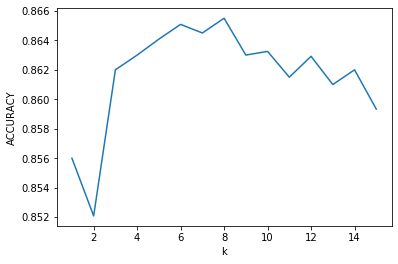

In [46]:
sns.lineplot(x="k", y="ACCURACY", data=df_scores)
df_scores

Видим, что здесь лучше выбирать k = 8.

In [44]:
pred_pca_knn8 = knn.predict(new_test_pca)

pred_pca_knn8 = pd.DataFrame(np.array(pred_pca_knn8), columns=['label'])

pred_pca_knn8['id']=range(1,10001)

pred_pca_knn8.to_csv('pred_pca_knn8.csv', index=False)

Получили результат 0.86433. Что немного лучше первоначального применения KNN без снижения размерности.

Попробуем изменить количество главных компонент и посмотрим какая будет точность на тестовой выборке. Будем менять количество компонент от 50 до 200 с шагом 50.

In [45]:
for n in range(50,250,50):
    X_pca = pca.transform(X)[:,:n]
    Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=8)
    knn.fit(Xtrain_pca, Ytrain_pca)
    print(n, "components" , end=': ')
    print(knn.score(Xtest_pca, Ytest_pca))

50 components: 0.8635833333333334
100 components: 0.8645833333333334
150 components: 0.8655833333333334
200 components: 0.8641666666666666


Для 150 компонент accuracy (0.8655833333333334) выше и с точностью до 4 знака совпадает с accuracy для 155 компонент (0.865500). Поэтому не будем строить прогноз для других размерностей.

### 4. RandomForest

Попробуем применить "случайный лес". Я пробовала применять разные параметры: изменяла критерий, максимальную глубину, ccp_alpha и количество деревьев (n_estimators). Приведенные ниже параметры, я посчитала оптимальными.

In [126]:
RF = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators = 300, random_state=0)

In [127]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
RF.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [128]:
RF.score(Xtest,Ytest)

0.8838333333333334

In [98]:
pred_RF = RF.predict(new_test)
pred_RF = pd.DataFrame(np.array(pred_RF), columns=['label'])

pred_RF['id']=range(1,10001)

pred_RF.to_csv('pred_RF.csv', index=False)

Для new_test получили точность 0.88533.

### 5. CatBoost

Пробуем CatBoost. Я изменяла количество итераций (500, 1000, 1500). Для 1500 точность получается выше. Увеличивать количество итераций я не стала, т.к. для 1500 вычисления занимают почти 1.5 часа.

In [47]:
cat = CatBoostClassifier(iterations = 1500)

In [155]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain, Ytrain)

Learning rate set to 0.068434
0:	learn: 2.0346992	total: 3.1s	remaining: 1h 17m 32s
1:	learn: 1.8489495	total: 6.18s	remaining: 1h 17m 10s
2:	learn: 1.7010860	total: 9.28s	remaining: 1h 17m 8s
3:	learn: 1.5890647	total: 12.3s	remaining: 1h 16m 55s
4:	learn: 1.4948560	total: 15.5s	remaining: 1h 17m 17s
5:	learn: 1.4147168	total: 18.6s	remaining: 1h 17m 20s
6:	learn: 1.3429199	total: 21.8s	remaining: 1h 17m 20s
7:	learn: 1.2789770	total: 24.9s	remaining: 1h 17m 16s
8:	learn: 1.2189065	total: 27.9s	remaining: 1h 17m 8s
9:	learn: 1.1693354	total: 31s	remaining: 1h 16m 57s
10:	learn: 1.1244262	total: 34.1s	remaining: 1h 16m 49s
11:	learn: 1.0823613	total: 37.1s	remaining: 1h 16m 43s
12:	learn: 1.0454652	total: 40.2s	remaining: 1h 16m 40s
13:	learn: 1.0100117	total: 43.5s	remaining: 1h 17m 1s
14:	learn: 0.9803764	total: 46.6s	remaining: 1h 16m 53s
15:	learn: 0.9492536	total: 49.7s	remaining: 1h 16m 52s
16:	learn: 0.9203142	total: 52.8s	remaining: 1h 16m 50s
17:	learn: 0.8957549	total: 56s	re

144:	learn: 0.3822831	total: 7m 36s	remaining: 1h 11m 2s
145:	learn: 0.3813250	total: 7m 39s	remaining: 1h 10m 59s
146:	learn: 0.3805518	total: 7m 42s	remaining: 1h 10m 56s
147:	learn: 0.3796483	total: 7m 45s	remaining: 1h 10m 53s
148:	learn: 0.3787006	total: 7m 48s	remaining: 1h 10m 49s
149:	learn: 0.3779484	total: 7m 51s	remaining: 1h 10m 45s
150:	learn: 0.3772453	total: 7m 54s	remaining: 1h 10m 42s
151:	learn: 0.3764229	total: 7m 57s	remaining: 1h 10m 38s
152:	learn: 0.3755302	total: 8m 1s	remaining: 1h 10m 35s
153:	learn: 0.3743891	total: 8m 4s	remaining: 1h 10m 31s
154:	learn: 0.3737179	total: 8m 7s	remaining: 1h 10m 27s
155:	learn: 0.3729135	total: 8m 10s	remaining: 1h 10m 24s
156:	learn: 0.3722334	total: 8m 13s	remaining: 1h 10m 20s
157:	learn: 0.3713216	total: 8m 16s	remaining: 1h 10m 17s
158:	learn: 0.3702396	total: 8m 19s	remaining: 1h 10m 13s
159:	learn: 0.3694758	total: 8m 22s	remaining: 1h 10m 10s
160:	learn: 0.3691482	total: 8m 25s	remaining: 1h 10m 6s
161:	learn: 0.36846

287:	learn: 0.3088121	total: 15m 3s	remaining: 1h 3m 23s
288:	learn: 0.3086510	total: 15m 7s	remaining: 1h 3m 20s
289:	learn: 0.3083039	total: 15m 10s	remaining: 1h 3m 17s
290:	learn: 0.3080710	total: 15m 13s	remaining: 1h 3m 14s
291:	learn: 0.3076835	total: 15m 16s	remaining: 1h 3m 10s
292:	learn: 0.3074191	total: 15m 19s	remaining: 1h 3m 7s
293:	learn: 0.3069626	total: 15m 22s	remaining: 1h 3m 4s
294:	learn: 0.3066939	total: 15m 25s	remaining: 1h 3m
295:	learn: 0.3060939	total: 15m 28s	remaining: 1h 2m 57s
296:	learn: 0.3054894	total: 15m 31s	remaining: 1h 2m 54s
297:	learn: 0.3049901	total: 15m 34s	remaining: 1h 2m 50s
298:	learn: 0.3045629	total: 15m 37s	remaining: 1h 2m 47s
299:	learn: 0.3044265	total: 15m 41s	remaining: 1h 2m 44s
300:	learn: 0.3040330	total: 15m 44s	remaining: 1h 2m 41s
301:	learn: 0.3034616	total: 15m 47s	remaining: 1h 2m 38s
302:	learn: 0.3028454	total: 15m 50s	remaining: 1h 2m 35s
303:	learn: 0.3025782	total: 15m 53s	remaining: 1h 2m 31s
304:	learn: 0.3023528	

434:	learn: 0.2723695	total: 22m 45s	remaining: 55m 42s
435:	learn: 0.2722329	total: 22m 48s	remaining: 55m 39s
436:	learn: 0.2720188	total: 22m 51s	remaining: 55m 36s
437:	learn: 0.2717151	total: 22m 54s	remaining: 55m 32s
438:	learn: 0.2715602	total: 22m 57s	remaining: 55m 29s
439:	learn: 0.2712815	total: 23m	remaining: 55m 26s
440:	learn: 0.2709975	total: 23m 3s	remaining: 55m 22s
441:	learn: 0.2706680	total: 23m 6s	remaining: 55m 19s
442:	learn: 0.2705367	total: 23m 10s	remaining: 55m 16s
443:	learn: 0.2701669	total: 23m 13s	remaining: 55m 13s
444:	learn: 0.2699705	total: 23m 16s	remaining: 55m 10s
445:	learn: 0.2696953	total: 23m 19s	remaining: 55m 7s
446:	learn: 0.2693085	total: 23m 22s	remaining: 55m 3s
447:	learn: 0.2692004	total: 23m 25s	remaining: 55m
448:	learn: 0.2689875	total: 23m 28s	remaining: 54m 57s
449:	learn: 0.2686200	total: 23m 31s	remaining: 54m 54s
450:	learn: 0.2683183	total: 23m 34s	remaining: 54m 50s
451:	learn: 0.2681147	total: 23m 37s	remaining: 54m 47s
452:

582:	learn: 0.2441244	total: 30m 25s	remaining: 47m 51s
583:	learn: 0.2440424	total: 30m 28s	remaining: 47m 48s
584:	learn: 0.2439516	total: 30m 31s	remaining: 47m 45s
585:	learn: 0.2438754	total: 30m 34s	remaining: 47m 42s
586:	learn: 0.2437793	total: 30m 38s	remaining: 47m 38s
587:	learn: 0.2436863	total: 30m 41s	remaining: 47m 35s
588:	learn: 0.2433962	total: 30m 44s	remaining: 47m 32s
589:	learn: 0.2432441	total: 30m 47s	remaining: 47m 29s
590:	learn: 0.2431361	total: 30m 50s	remaining: 47m 26s
591:	learn: 0.2430572	total: 30m 53s	remaining: 47m 22s
592:	learn: 0.2429380	total: 30m 56s	remaining: 47m 19s
593:	learn: 0.2427785	total: 30m 59s	remaining: 47m 16s
594:	learn: 0.2426364	total: 31m 2s	remaining: 47m 13s
595:	learn: 0.2424426	total: 31m 5s	remaining: 47m 10s
596:	learn: 0.2422139	total: 31m 9s	remaining: 47m 7s
597:	learn: 0.2421049	total: 31m 12s	remaining: 47m 3s
598:	learn: 0.2419592	total: 31m 15s	remaining: 47m
599:	learn: 0.2418546	total: 31m 18s	remaining: 46m 57s
6

730:	learn: 0.2252707	total: 38m 6s	remaining: 40m 5s
731:	learn: 0.2251713	total: 38m 9s	remaining: 40m 1s
732:	learn: 0.2250973	total: 38m 12s	remaining: 39m 58s
733:	learn: 0.2250509	total: 38m 15s	remaining: 39m 55s
734:	learn: 0.2249316	total: 38m 18s	remaining: 39m 52s
735:	learn: 0.2248063	total: 38m 22s	remaining: 39m 49s
736:	learn: 0.2245993	total: 38m 25s	remaining: 39m 46s
737:	learn: 0.2244851	total: 38m 28s	remaining: 39m 43s
738:	learn: 0.2244377	total: 38m 31s	remaining: 39m 40s
739:	learn: 0.2242783	total: 38m 34s	remaining: 39m 36s
740:	learn: 0.2241118	total: 38m 37s	remaining: 39m 33s
741:	learn: 0.2239427	total: 38m 40s	remaining: 39m 30s
742:	learn: 0.2238155	total: 38m 43s	remaining: 39m 27s
743:	learn: 0.2236521	total: 38m 46s	remaining: 39m 24s
744:	learn: 0.2235856	total: 38m 49s	remaining: 39m 21s
745:	learn: 0.2235123	total: 38m 52s	remaining: 39m 17s
746:	learn: 0.2233689	total: 38m 55s	remaining: 39m 14s
747:	learn: 0.2233129	total: 38m 59s	remaining: 39m 

878:	learn: 0.2084924	total: 45m 44s	remaining: 32m 18s
879:	learn: 0.2084127	total: 45m 47s	remaining: 32m 15s
880:	learn: 0.2082960	total: 45m 50s	remaining: 32m 12s
881:	learn: 0.2081783	total: 45m 53s	remaining: 32m 9s
882:	learn: 0.2079373	total: 45m 56s	remaining: 32m 6s
883:	learn: 0.2077816	total: 45m 59s	remaining: 32m 3s
884:	learn: 0.2077405	total: 46m 2s	remaining: 31m 59s
885:	learn: 0.2077051	total: 46m 5s	remaining: 31m 56s
886:	learn: 0.2076545	total: 46m 8s	remaining: 31m 53s
887:	learn: 0.2075429	total: 46m 11s	remaining: 31m 50s
888:	learn: 0.2074707	total: 46m 15s	remaining: 31m 47s
889:	learn: 0.2072112	total: 46m 18s	remaining: 31m 44s
890:	learn: 0.2071409	total: 46m 21s	remaining: 31m 41s
891:	learn: 0.2070108	total: 46m 24s	remaining: 31m 37s
892:	learn: 0.2069194	total: 46m 27s	remaining: 31m 34s
893:	learn: 0.2067982	total: 46m 30s	remaining: 31m 31s
894:	learn: 0.2066399	total: 46m 33s	remaining: 31m 28s
895:	learn: 0.2066061	total: 46m 36s	remaining: 31m 25

1025:	learn: 0.1948078	total: 53m 19s	remaining: 24m 38s
1026:	learn: 0.1947658	total: 53m 23s	remaining: 24m 35s
1027:	learn: 0.1946613	total: 53m 26s	remaining: 24m 32s
1028:	learn: 0.1945869	total: 53m 29s	remaining: 24m 28s
1029:	learn: 0.1945043	total: 53m 32s	remaining: 24m 25s
1030:	learn: 0.1944903	total: 53m 35s	remaining: 24m 22s
1031:	learn: 0.1944316	total: 53m 38s	remaining: 24m 19s
1032:	learn: 0.1943575	total: 53m 41s	remaining: 24m 16s
1033:	learn: 0.1941974	total: 53m 44s	remaining: 24m 13s
1034:	learn: 0.1939910	total: 53m 47s	remaining: 24m 10s
1035:	learn: 0.1939198	total: 53m 50s	remaining: 24m 6s
1036:	learn: 0.1938860	total: 53m 53s	remaining: 24m 3s
1037:	learn: 0.1938157	total: 53m 56s	remaining: 24m
1038:	learn: 0.1937089	total: 53m 59s	remaining: 23m 57s
1039:	learn: 0.1936235	total: 54m 3s	remaining: 23m 54s
1040:	learn: 0.1934948	total: 54m 6s	remaining: 23m 51s
1041:	learn: 0.1934733	total: 54m 9s	remaining: 23m 48s
1042:	learn: 0.1933971	total: 54m 12s	re

1171:	learn: 0.1831520	total: 1h 49s	remaining: 17m 1s
1172:	learn: 0.1830932	total: 1h 52s	remaining: 16m 58s
1173:	learn: 0.1830595	total: 1h 55s	remaining: 16m 55s
1174:	learn: 0.1830216	total: 1h 58s	remaining: 16m 52s
1175:	learn: 0.1829185	total: 1h 1m 2s	remaining: 16m 48s
1176:	learn: 0.1828280	total: 1h 1m 5s	remaining: 16m 45s
1177:	learn: 0.1827862	total: 1h 1m 8s	remaining: 16m 42s
1178:	learn: 0.1827181	total: 1h 1m 11s	remaining: 16m 39s
1179:	learn: 0.1826716	total: 1h 1m 14s	remaining: 16m 36s
1180:	learn: 0.1826348	total: 1h 1m 17s	remaining: 16m 33s
1181:	learn: 0.1825725	total: 1h 1m 20s	remaining: 16m 30s
1182:	learn: 0.1825493	total: 1h 1m 23s	remaining: 16m 27s
1183:	learn: 0.1823150	total: 1h 1m 26s	remaining: 16m 23s
1184:	learn: 0.1822196	total: 1h 1m 29s	remaining: 16m 20s
1185:	learn: 0.1821490	total: 1h 1m 32s	remaining: 16m 17s
1186:	learn: 0.1819977	total: 1h 1m 35s	remaining: 16m 14s
1187:	learn: 0.1818726	total: 1h 1m 38s	remaining: 16m 11s
1188:	learn: 

1312:	learn: 0.1727152	total: 1h 8m 8s	remaining: 9m 42s
1313:	learn: 0.1726205	total: 1h 8m 11s	remaining: 9m 39s
1314:	learn: 0.1725183	total: 1h 8m 14s	remaining: 9m 36s
1315:	learn: 0.1724833	total: 1h 8m 17s	remaining: 9m 32s
1316:	learn: 0.1723735	total: 1h 8m 20s	remaining: 9m 29s
1317:	learn: 0.1723166	total: 1h 8m 23s	remaining: 9m 26s
1318:	learn: 0.1722887	total: 1h 8m 26s	remaining: 9m 23s
1319:	learn: 0.1721803	total: 1h 8m 29s	remaining: 9m 20s
1320:	learn: 0.1721557	total: 1h 8m 33s	remaining: 9m 17s
1321:	learn: 0.1721109	total: 1h 8m 36s	remaining: 9m 14s
1322:	learn: 0.1720304	total: 1h 8m 39s	remaining: 9m 11s
1323:	learn: 0.1719313	total: 1h 8m 42s	remaining: 9m 7s
1324:	learn: 0.1718658	total: 1h 8m 45s	remaining: 9m 4s
1325:	learn: 0.1717839	total: 1h 8m 48s	remaining: 9m 1s
1326:	learn: 0.1717599	total: 1h 8m 51s	remaining: 8m 58s
1327:	learn: 0.1717294	total: 1h 8m 54s	remaining: 8m 55s
1328:	learn: 0.1716870	total: 1h 8m 57s	remaining: 8m 52s
1329:	learn: 0.171

1453:	learn: 0.1636068	total: 1h 15m 28s	remaining: 2m 23s
1454:	learn: 0.1634711	total: 1h 15m 31s	remaining: 2m 20s
1455:	learn: 0.1634330	total: 1h 15m 34s	remaining: 2m 17s
1456:	learn: 0.1633355	total: 1h 15m 38s	remaining: 2m 13s
1457:	learn: 0.1632503	total: 1h 15m 41s	remaining: 2m 10s
1458:	learn: 0.1632261	total: 1h 15m 44s	remaining: 2m 7s
1459:	learn: 0.1631648	total: 1h 15m 47s	remaining: 2m 4s
1460:	learn: 0.1631441	total: 1h 15m 50s	remaining: 2m 1s
1461:	learn: 0.1630841	total: 1h 15m 53s	remaining: 1m 58s
1462:	learn: 0.1629795	total: 1h 15m 56s	remaining: 1m 55s
1463:	learn: 0.1629376	total: 1h 15m 59s	remaining: 1m 52s
1464:	learn: 0.1628419	total: 1h 16m 2s	remaining: 1m 49s
1465:	learn: 0.1627791	total: 1h 16m 5s	remaining: 1m 45s
1466:	learn: 0.1627318	total: 1h 16m 9s	remaining: 1m 42s
1467:	learn: 0.1626381	total: 1h 16m 12s	remaining: 1m 39s
1468:	learn: 0.1626023	total: 1h 16m 15s	remaining: 1m 36s
1469:	learn: 0.1625374	total: 1h 16m 18s	remaining: 1m 33s
147

In [156]:
cat.score(Xtest,Ytest)

0.8988333333333334

In [157]:
pred_cat = cat.predict(new_test)
pred_cat = pd.DataFrame(np.array(pred_cat), columns=['label'])

pred_cat['id']=range(1,10001)

pred_cat.to_csv('pred_cat.csv', index=False)

Получили точность для new_test 0.90900. И это наилучший результат.

Применим CatBoost с PCA.

In [48]:
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain1, Ytrain1)

Learning rate set to 0.068434
0:	learn: 2.0679537	total: 743ms	remaining: 18m 33s
1:	learn: 1.8946509	total: 1.48s	remaining: 18m 25s
2:	learn: 1.7637615	total: 2.19s	remaining: 18m 15s
3:	learn: 1.6683770	total: 3.04s	remaining: 18m 57s
4:	learn: 1.5707910	total: 3.75s	remaining: 18m 41s
5:	learn: 1.4972349	total: 4.46s	remaining: 18m 30s
6:	learn: 1.4333444	total: 5.17s	remaining: 18m 22s
7:	learn: 1.3776403	total: 5.95s	remaining: 18m 30s
8:	learn: 1.3265000	total: 6.68s	remaining: 18m 27s
9:	learn: 1.2805997	total: 7.46s	remaining: 18m 31s
10:	learn: 1.2364084	total: 8.17s	remaining: 18m 25s
11:	learn: 1.1951583	total: 8.88s	remaining: 18m 21s
12:	learn: 1.1604033	total: 9.6s	remaining: 18m 17s
13:	learn: 1.1264376	total: 10.3s	remaining: 18m 13s
14:	learn: 1.0975418	total: 11s	remaining: 18m 10s
15:	learn: 1.0719518	total: 11.8s	remaining: 18m 16s
16:	learn: 1.0443806	total: 12.7s	remaining: 18m 32s
17:	learn: 1.0154597	total: 13.5s	remaining: 18m 34s
18:	learn: 0.9930223	total: 1

153:	learn: 0.4242254	total: 1m 52s	remaining: 16m 20s
154:	learn: 0.4230252	total: 1m 52s	remaining: 16m 18s
155:	learn: 0.4219361	total: 1m 53s	remaining: 16m 17s
156:	learn: 0.4211461	total: 1m 54s	remaining: 16m 16s
157:	learn: 0.4205241	total: 1m 54s	remaining: 16m 15s
158:	learn: 0.4194766	total: 1m 55s	remaining: 16m 14s
159:	learn: 0.4186179	total: 1m 56s	remaining: 16m 13s
160:	learn: 0.4177944	total: 1m 56s	remaining: 16m 12s
161:	learn: 0.4164586	total: 1m 57s	remaining: 16m 11s
162:	learn: 0.4155588	total: 1m 58s	remaining: 16m 10s
163:	learn: 0.4145163	total: 1m 58s	remaining: 16m 9s
164:	learn: 0.4136039	total: 1m 59s	remaining: 16m 8s
165:	learn: 0.4129392	total: 2m	remaining: 16m 7s
166:	learn: 0.4117416	total: 2m 1s	remaining: 16m 6s
167:	learn: 0.4112564	total: 2m 1s	remaining: 16m 5s
168:	learn: 0.4104758	total: 2m 2s	remaining: 16m 4s
169:	learn: 0.4095994	total: 2m 3s	remaining: 16m 3s
170:	learn: 0.4090802	total: 2m 3s	remaining: 16m 1s
171:	learn: 0.4081731	total

304:	learn: 0.3336194	total: 3m 35s	remaining: 14m 5s
305:	learn: 0.3331708	total: 3m 36s	remaining: 14m 4s
306:	learn: 0.3328069	total: 3m 37s	remaining: 14m 3s
307:	learn: 0.3324547	total: 3m 37s	remaining: 14m 3s
308:	learn: 0.3319509	total: 3m 38s	remaining: 14m 2s
309:	learn: 0.3312778	total: 3m 39s	remaining: 14m 1s
310:	learn: 0.3309039	total: 3m 39s	remaining: 14m
311:	learn: 0.3303563	total: 3m 40s	remaining: 13m 59s
312:	learn: 0.3301348	total: 3m 41s	remaining: 13m 59s
313:	learn: 0.3297355	total: 3m 41s	remaining: 13m 58s
314:	learn: 0.3294942	total: 3m 42s	remaining: 13m 57s
315:	learn: 0.3291771	total: 3m 43s	remaining: 13m 56s
316:	learn: 0.3290329	total: 3m 44s	remaining: 13m 56s
317:	learn: 0.3285109	total: 3m 44s	remaining: 13m 55s
318:	learn: 0.3282216	total: 3m 45s	remaining: 13m 54s
319:	learn: 0.3278437	total: 3m 46s	remaining: 13m 54s
320:	learn: 0.3274843	total: 3m 46s	remaining: 13m 53s
321:	learn: 0.3272690	total: 3m 47s	remaining: 13m 52s
322:	learn: 0.326793

455:	learn: 0.2880606	total: 5m 20s	remaining: 12m 14s
456:	learn: 0.2878008	total: 5m 21s	remaining: 12m 13s
457:	learn: 0.2874177	total: 5m 22s	remaining: 12m 12s
458:	learn: 0.2872256	total: 5m 22s	remaining: 12m 12s
459:	learn: 0.2869639	total: 5m 23s	remaining: 12m 11s
460:	learn: 0.2867811	total: 5m 24s	remaining: 12m 10s
461:	learn: 0.2865868	total: 5m 24s	remaining: 12m 9s
462:	learn: 0.2861792	total: 5m 25s	remaining: 12m 9s
463:	learn: 0.2859470	total: 5m 26s	remaining: 12m 8s
464:	learn: 0.2856961	total: 5m 26s	remaining: 12m 7s
465:	learn: 0.2855395	total: 5m 27s	remaining: 12m 6s
466:	learn: 0.2852548	total: 5m 28s	remaining: 12m 6s
467:	learn: 0.2848565	total: 5m 28s	remaining: 12m 5s
468:	learn: 0.2847297	total: 5m 29s	remaining: 12m 4s
469:	learn: 0.2845923	total: 5m 30s	remaining: 12m 3s
470:	learn: 0.2844111	total: 5m 30s	remaining: 12m 3s
471:	learn: 0.2841778	total: 5m 31s	remaining: 12m 2s
472:	learn: 0.2838696	total: 5m 32s	remaining: 12m 1s
473:	learn: 0.2836691	

606:	learn: 0.2557297	total: 7m 14s	remaining: 10m 39s
607:	learn: 0.2554232	total: 7m 15s	remaining: 10m 38s
608:	learn: 0.2553154	total: 7m 16s	remaining: 10m 37s
609:	learn: 0.2552106	total: 7m 17s	remaining: 10m 37s
610:	learn: 0.2550925	total: 7m 17s	remaining: 10m 36s
611:	learn: 0.2548564	total: 7m 18s	remaining: 10m 36s
612:	learn: 0.2546988	total: 7m 19s	remaining: 10m 35s
613:	learn: 0.2544918	total: 7m 19s	remaining: 10m 34s
614:	learn: 0.2543187	total: 7m 20s	remaining: 10m 34s
615:	learn: 0.2540803	total: 7m 21s	remaining: 10m 33s
616:	learn: 0.2539528	total: 7m 22s	remaining: 10m 32s
617:	learn: 0.2537461	total: 7m 22s	remaining: 10m 32s
618:	learn: 0.2535678	total: 7m 23s	remaining: 10m 31s
619:	learn: 0.2533081	total: 7m 24s	remaining: 10m 30s
620:	learn: 0.2531678	total: 7m 25s	remaining: 10m 30s
621:	learn: 0.2530219	total: 7m 25s	remaining: 10m 29s
622:	learn: 0.2527762	total: 7m 26s	remaining: 10m 28s
623:	learn: 0.2525658	total: 7m 27s	remaining: 10m 27s
624:	learn

759:	learn: 0.2289172	total: 9m 12s	remaining: 8m 57s
760:	learn: 0.2287889	total: 9m 13s	remaining: 8m 57s
761:	learn: 0.2286578	total: 9m 14s	remaining: 8m 56s
762:	learn: 0.2286024	total: 9m 15s	remaining: 8m 56s
763:	learn: 0.2283189	total: 9m 16s	remaining: 8m 55s
764:	learn: 0.2281960	total: 9m 16s	remaining: 8m 55s
765:	learn: 0.2280630	total: 9m 17s	remaining: 8m 54s
766:	learn: 0.2278970	total: 9m 18s	remaining: 8m 53s
767:	learn: 0.2277936	total: 9m 19s	remaining: 8m 53s
768:	learn: 0.2275960	total: 9m 20s	remaining: 8m 52s
769:	learn: 0.2274345	total: 9m 20s	remaining: 8m 51s
770:	learn: 0.2272998	total: 9m 21s	remaining: 8m 51s
771:	learn: 0.2271696	total: 9m 22s	remaining: 8m 50s
772:	learn: 0.2269614	total: 9m 23s	remaining: 8m 49s
773:	learn: 0.2268356	total: 9m 24s	remaining: 8m 49s
774:	learn: 0.2267427	total: 9m 24s	remaining: 8m 48s
775:	learn: 0.2265653	total: 9m 25s	remaining: 8m 47s
776:	learn: 0.2264261	total: 9m 26s	remaining: 8m 46s
777:	learn: 0.2263535	total:

911:	learn: 0.2074467	total: 11m 10s	remaining: 7m 12s
912:	learn: 0.2073472	total: 11m 11s	remaining: 7m 11s
913:	learn: 0.2071974	total: 11m 12s	remaining: 7m 10s
914:	learn: 0.2071421	total: 11m 12s	remaining: 7m 10s
915:	learn: 0.2069864	total: 11m 13s	remaining: 7m 9s
916:	learn: 0.2067943	total: 11m 14s	remaining: 7m 8s
917:	learn: 0.2067338	total: 11m 15s	remaining: 7m 8s
918:	learn: 0.2065598	total: 11m 16s	remaining: 7m 7s
919:	learn: 0.2064020	total: 11m 16s	remaining: 7m 6s
920:	learn: 0.2061749	total: 11m 17s	remaining: 7m 6s
921:	learn: 0.2060267	total: 11m 18s	remaining: 7m 5s
922:	learn: 0.2059055	total: 11m 19s	remaining: 7m 4s
923:	learn: 0.2056622	total: 11m 19s	remaining: 7m 3s
924:	learn: 0.2054689	total: 11m 20s	remaining: 7m 3s
925:	learn: 0.2053551	total: 11m 21s	remaining: 7m 2s
926:	learn: 0.2051959	total: 11m 22s	remaining: 7m 1s
927:	learn: 0.2050866	total: 11m 22s	remaining: 7m
928:	learn: 0.2049658	total: 11m 23s	remaining: 7m
929:	learn: 0.2048373	total: 1

1061:	learn: 0.1882556	total: 13m 7s	remaining: 5m 24s
1062:	learn: 0.1881308	total: 13m 7s	remaining: 5m 23s
1063:	learn: 0.1880782	total: 13m 8s	remaining: 5m 23s
1064:	learn: 0.1879844	total: 13m 9s	remaining: 5m 22s
1065:	learn: 0.1878963	total: 13m 10s	remaining: 5m 21s
1066:	learn: 0.1877956	total: 13m 10s	remaining: 5m 20s
1067:	learn: 0.1876903	total: 13m 11s	remaining: 5m 20s
1068:	learn: 0.1876407	total: 13m 12s	remaining: 5m 19s
1069:	learn: 0.1874945	total: 13m 12s	remaining: 5m 18s
1070:	learn: 0.1872879	total: 13m 13s	remaining: 5m 17s
1071:	learn: 0.1871292	total: 13m 14s	remaining: 5m 17s
1072:	learn: 0.1870197	total: 13m 14s	remaining: 5m 16s
1073:	learn: 0.1868400	total: 13m 15s	remaining: 5m 15s
1074:	learn: 0.1866987	total: 13m 16s	remaining: 5m 14s
1075:	learn: 0.1865637	total: 13m 17s	remaining: 5m 14s
1076:	learn: 0.1863388	total: 13m 18s	remaining: 5m 13s
1077:	learn: 0.1861298	total: 13m 19s	remaining: 5m 12s
1078:	learn: 0.1859086	total: 13m 20s	remaining: 5m 

1209:	learn: 0.1713341	total: 15m 6s	remaining: 3m 37s
1210:	learn: 0.1712307	total: 15m 7s	remaining: 3m 36s
1211:	learn: 0.1711687	total: 15m 8s	remaining: 3m 35s
1212:	learn: 0.1710295	total: 15m 9s	remaining: 3m 35s
1213:	learn: 0.1708908	total: 15m 9s	remaining: 3m 34s
1214:	learn: 0.1708460	total: 15m 10s	remaining: 3m 33s
1215:	learn: 0.1707798	total: 15m 11s	remaining: 3m 32s
1216:	learn: 0.1706834	total: 15m 11s	remaining: 3m 32s
1217:	learn: 0.1706063	total: 15m 12s	remaining: 3m 31s
1218:	learn: 0.1705599	total: 15m 13s	remaining: 3m 30s
1219:	learn: 0.1704657	total: 15m 14s	remaining: 3m 29s
1220:	learn: 0.1703887	total: 15m 15s	remaining: 3m 29s
1221:	learn: 0.1703131	total: 15m 15s	remaining: 3m 28s
1222:	learn: 0.1701993	total: 15m 16s	remaining: 3m 27s
1223:	learn: 0.1700353	total: 15m 17s	remaining: 3m 26s
1224:	learn: 0.1699771	total: 15m 17s	remaining: 3m 26s
1225:	learn: 0.1699193	total: 15m 18s	remaining: 3m 25s
1226:	learn: 0.1698174	total: 15m 19s	remaining: 3m 2

1357:	learn: 0.1563946	total: 17m 1s	remaining: 1m 46s
1358:	learn: 0.1563339	total: 17m 2s	remaining: 1m 46s
1359:	learn: 0.1562605	total: 17m 3s	remaining: 1m 45s
1360:	learn: 0.1562097	total: 17m 4s	remaining: 1m 44s
1361:	learn: 0.1561030	total: 17m 4s	remaining: 1m 43s
1362:	learn: 0.1560208	total: 17m 5s	remaining: 1m 43s
1363:	learn: 0.1559177	total: 17m 6s	remaining: 1m 42s
1364:	learn: 0.1558930	total: 17m 7s	remaining: 1m 41s
1365:	learn: 0.1557726	total: 17m 8s	remaining: 1m 40s
1366:	learn: 0.1557127	total: 17m 9s	remaining: 1m 40s
1367:	learn: 0.1556844	total: 17m 9s	remaining: 1m 39s
1368:	learn: 0.1555140	total: 17m 10s	remaining: 1m 38s
1369:	learn: 0.1554206	total: 17m 11s	remaining: 1m 37s
1370:	learn: 0.1553251	total: 17m 12s	remaining: 1m 37s
1371:	learn: 0.1552769	total: 17m 13s	remaining: 1m 36s
1372:	learn: 0.1552420	total: 17m 13s	remaining: 1m 35s
1373:	learn: 0.1551559	total: 17m 14s	remaining: 1m 34s
1374:	learn: 0.1549873	total: 17m 15s	remaining: 1m 34s
137

In [49]:
cat.score(Xtest1,Ytest1)

0.8864166666666666

Accuracy получилась ниже, чем без применения PCA. Поэтому не будем делать прогноз.

### 6. Снижение размерности (t-SNE)

Применим t-SNE.

In [50]:
X_tsne = TSNE(random_state=42).fit_transform(X)
X_tsne.shape   

(60000, 2)

Визуализируем полученный результат.

In [68]:
import matplotlib.patheffects as PathEffects
def scatter(x, colors):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(classes[i]), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(9.982557, 7.182563, 'T-shirt/top'),
  Text(35.211304, 26.47134, 'Trouser'),
  Text(-32.896416, 5.086321, 'Pullover'),
  Text(2.5122082, 35.505573, 'Dress'),
  Text(-29.994047, 17.383904, 'Coat'),
  Text(18.708443, -16.584656, 'Sandal'),
  Text(-16.443384, 7.231048, 'Shirt'),
  Text(38.189346, -17.533527, 'Sneaker'),
  Text(-22.299942, -24.515429, 'Bag'),
  Text(1.9103718, -42.378136, 'Ankle boot')])

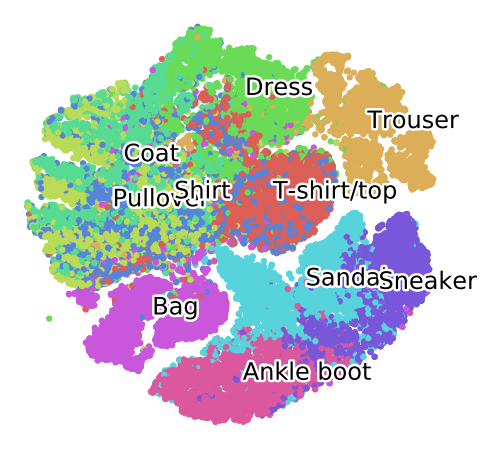

In [69]:
scatter(X_tsne, Y)

Из графика видим, что брюки и сумки хорошо отделяются от остальных классов.

Применим к нему CatBoost.

In [53]:
Xtrain_tsne, Xtest_tsne, Ytrain_tsne, Ytest_tsne = train_test_split(X_tsne, Y, test_size=0.2, random_state=42)
cat.fit(Xtrain_tsne, Ytrain_tsne)

Learning rate set to 0.068434
0:	learn: 2.0279239	total: 40.1ms	remaining: 1m
1:	learn: 1.8405964	total: 70.1ms	remaining: 52.5s
2:	learn: 1.7058230	total: 99.6ms	remaining: 49.7s
3:	learn: 1.5946238	total: 129ms	remaining: 48.3s
4:	learn: 1.5077510	total: 159ms	remaining: 47.4s
5:	learn: 1.4305525	total: 189ms	remaining: 47.1s
6:	learn: 1.3628503	total: 225ms	remaining: 47.9s
7:	learn: 1.3051183	total: 254ms	remaining: 47.4s
8:	learn: 1.2544272	total: 284ms	remaining: 47s
9:	learn: 1.2077015	total: 313ms	remaining: 46.7s
10:	learn: 1.1649183	total: 343ms	remaining: 46.4s
11:	learn: 1.1270717	total: 372ms	remaining: 46.1s
12:	learn: 1.0942429	total: 408ms	remaining: 46.7s
13:	learn: 1.0616643	total: 438ms	remaining: 46.5s
14:	learn: 1.0342217	total: 468ms	remaining: 46.3s
15:	learn: 1.0073657	total: 499ms	remaining: 46.3s
16:	learn: 0.9828535	total: 528ms	remaining: 46.1s
17:	learn: 0.9616695	total: 558ms	remaining: 45.9s
18:	learn: 0.9413676	total: 593ms	remaining: 46.2s
19:	learn: 0.

164:	learn: 0.5696361	total: 5.44s	remaining: 44s
165:	learn: 0.5693104	total: 5.48s	remaining: 44s
166:	learn: 0.5689130	total: 5.51s	remaining: 44s
167:	learn: 0.5685350	total: 5.54s	remaining: 43.9s
168:	learn: 0.5680683	total: 5.57s	remaining: 43.9s
169:	learn: 0.5677352	total: 5.61s	remaining: 43.9s
170:	learn: 0.5673172	total: 5.64s	remaining: 43.9s
171:	learn: 0.5669645	total: 5.68s	remaining: 43.8s
172:	learn: 0.5665960	total: 5.71s	remaining: 43.8s
173:	learn: 0.5663462	total: 5.74s	remaining: 43.8s
174:	learn: 0.5659615	total: 5.77s	remaining: 43.7s
175:	learn: 0.5656477	total: 5.81s	remaining: 43.7s
176:	learn: 0.5652326	total: 5.85s	remaining: 43.7s
177:	learn: 0.5649906	total: 5.89s	remaining: 43.8s
178:	learn: 0.5644957	total: 5.94s	remaining: 43.8s
179:	learn: 0.5641862	total: 5.99s	remaining: 43.9s
180:	learn: 0.5638282	total: 6.03s	remaining: 44s
181:	learn: 0.5634457	total: 6.07s	remaining: 44s
182:	learn: 0.5630798	total: 6.11s	remaining: 43.9s
183:	learn: 0.5628722	

324:	learn: 0.5303115	total: 10.9s	remaining: 39.4s
325:	learn: 0.5301197	total: 10.9s	remaining: 39.4s
326:	learn: 0.5299320	total: 11s	remaining: 39.4s
327:	learn: 0.5297387	total: 11s	remaining: 39.3s
328:	learn: 0.5296186	total: 11s	remaining: 39.3s
329:	learn: 0.5295073	total: 11.1s	remaining: 39.2s
330:	learn: 0.5294341	total: 11.1s	remaining: 39.2s
331:	learn: 0.5293237	total: 11.1s	remaining: 39.2s
332:	learn: 0.5292612	total: 11.2s	remaining: 39.2s
333:	learn: 0.5287635	total: 11.2s	remaining: 39.2s
334:	learn: 0.5286760	total: 11.3s	remaining: 39.1s
335:	learn: 0.5283286	total: 11.3s	remaining: 39.1s
336:	learn: 0.5281642	total: 11.3s	remaining: 39.1s
337:	learn: 0.5280196	total: 11.4s	remaining: 39.1s
338:	learn: 0.5278564	total: 11.4s	remaining: 39s
339:	learn: 0.5276267	total: 11.4s	remaining: 39s
340:	learn: 0.5275232	total: 11.5s	remaining: 39s
341:	learn: 0.5274182	total: 11.5s	remaining: 39s
342:	learn: 0.5273338	total: 11.5s	remaining: 38.9s
343:	learn: 0.5271938	tota

488:	learn: 0.5091865	total: 17.1s	remaining: 35.4s
489:	learn: 0.5091312	total: 17.2s	remaining: 35.4s
490:	learn: 0.5090370	total: 17.2s	remaining: 35.3s
491:	learn: 0.5089545	total: 17.2s	remaining: 35.3s
492:	learn: 0.5089336	total: 17.3s	remaining: 35.2s
493:	learn: 0.5088731	total: 17.3s	remaining: 35.3s
494:	learn: 0.5088211	total: 17.4s	remaining: 35.3s
495:	learn: 0.5087648	total: 17.4s	remaining: 35.2s
496:	learn: 0.5086771	total: 17.4s	remaining: 35.2s
497:	learn: 0.5086232	total: 17.5s	remaining: 35.2s
498:	learn: 0.5083875	total: 17.5s	remaining: 35.1s
499:	learn: 0.5083104	total: 17.6s	remaining: 35.1s
500:	learn: 0.5081038	total: 17.6s	remaining: 35.1s
501:	learn: 0.5080150	total: 17.6s	remaining: 35s
502:	learn: 0.5079788	total: 17.7s	remaining: 35s
503:	learn: 0.5078547	total: 17.7s	remaining: 35s
504:	learn: 0.5077776	total: 17.7s	remaining: 34.9s
505:	learn: 0.5076126	total: 17.8s	remaining: 34.9s
506:	learn: 0.5075328	total: 17.8s	remaining: 34.8s
507:	learn: 0.5074

652:	learn: 0.4951239	total: 22.9s	remaining: 29.7s
653:	learn: 0.4950731	total: 22.9s	remaining: 29.6s
654:	learn: 0.4950380	total: 22.9s	remaining: 29.6s
655:	learn: 0.4949845	total: 23s	remaining: 29.6s
656:	learn: 0.4949010	total: 23s	remaining: 29.5s
657:	learn: 0.4948711	total: 23s	remaining: 29.5s
658:	learn: 0.4948545	total: 23.1s	remaining: 29.4s
659:	learn: 0.4948268	total: 23.1s	remaining: 29.4s
660:	learn: 0.4947776	total: 23.1s	remaining: 29.4s
661:	learn: 0.4946568	total: 23.2s	remaining: 29.3s
662:	learn: 0.4946092	total: 23.2s	remaining: 29.3s
663:	learn: 0.4944919	total: 23.2s	remaining: 29.2s
664:	learn: 0.4944457	total: 23.3s	remaining: 29.2s
665:	learn: 0.4944268	total: 23.3s	remaining: 29.2s
666:	learn: 0.4943164	total: 23.3s	remaining: 29.1s
667:	learn: 0.4942447	total: 23.4s	remaining: 29.1s
668:	learn: 0.4941827	total: 23.4s	remaining: 29.1s
669:	learn: 0.4939569	total: 23.4s	remaining: 29s
670:	learn: 0.4939127	total: 23.5s	remaining: 29s
671:	learn: 0.4938812	

812:	learn: 0.4842357	total: 28.3s	remaining: 24s
813:	learn: 0.4841487	total: 28.4s	remaining: 23.9s
814:	learn: 0.4840975	total: 28.4s	remaining: 23.9s
815:	learn: 0.4840587	total: 28.5s	remaining: 23.9s
816:	learn: 0.4840311	total: 28.5s	remaining: 23.8s
817:	learn: 0.4840052	total: 28.5s	remaining: 23.8s
818:	learn: 0.4839596	total: 28.6s	remaining: 23.8s
819:	learn: 0.4839386	total: 28.6s	remaining: 23.7s
820:	learn: 0.4838614	total: 28.6s	remaining: 23.7s
821:	learn: 0.4838190	total: 28.7s	remaining: 23.7s
822:	learn: 0.4837286	total: 28.7s	remaining: 23.6s
823:	learn: 0.4837015	total: 28.7s	remaining: 23.6s
824:	learn: 0.4836280	total: 28.8s	remaining: 23.5s
825:	learn: 0.4835495	total: 28.8s	remaining: 23.5s
826:	learn: 0.4835296	total: 28.8s	remaining: 23.5s
827:	learn: 0.4834834	total: 28.9s	remaining: 23.4s
828:	learn: 0.4834075	total: 28.9s	remaining: 23.4s
829:	learn: 0.4833698	total: 28.9s	remaining: 23.3s
830:	learn: 0.4833311	total: 29s	remaining: 23.3s
831:	learn: 0.48

972:	learn: 0.4760998	total: 33.5s	remaining: 18.1s
973:	learn: 0.4760758	total: 33.5s	remaining: 18.1s
974:	learn: 0.4760567	total: 33.5s	remaining: 18.1s
975:	learn: 0.4760321	total: 33.6s	remaining: 18s
976:	learn: 0.4759899	total: 33.6s	remaining: 18s
977:	learn: 0.4759738	total: 33.6s	remaining: 18s
978:	learn: 0.4758704	total: 33.7s	remaining: 17.9s
979:	learn: 0.4758132	total: 33.7s	remaining: 17.9s
980:	learn: 0.4757560	total: 33.8s	remaining: 17.9s
981:	learn: 0.4757092	total: 33.8s	remaining: 17.8s
982:	learn: 0.4756403	total: 33.8s	remaining: 17.8s
983:	learn: 0.4754898	total: 33.9s	remaining: 17.8s
984:	learn: 0.4754712	total: 33.9s	remaining: 17.7s
985:	learn: 0.4754266	total: 34s	remaining: 17.7s
986:	learn: 0.4753744	total: 34s	remaining: 17.7s
987:	learn: 0.4753520	total: 34s	remaining: 17.6s
988:	learn: 0.4753297	total: 34.1s	remaining: 17.6s
989:	learn: 0.4753076	total: 34.1s	remaining: 17.6s
990:	learn: 0.4752934	total: 34.1s	remaining: 17.5s
991:	learn: 0.4752418	to

1132:	learn: 0.4688265	total: 39.2s	remaining: 12.7s
1133:	learn: 0.4687802	total: 39.3s	remaining: 12.7s
1134:	learn: 0.4687428	total: 39.3s	remaining: 12.6s
1135:	learn: 0.4687002	total: 39.4s	remaining: 12.6s
1136:	learn: 0.4686523	total: 39.4s	remaining: 12.6s
1137:	learn: 0.4686400	total: 39.5s	remaining: 12.6s
1138:	learn: 0.4686225	total: 39.5s	remaining: 12.5s
1139:	learn: 0.4686097	total: 39.5s	remaining: 12.5s
1140:	learn: 0.4685881	total: 39.6s	remaining: 12.5s
1141:	learn: 0.4685745	total: 39.6s	remaining: 12.4s
1142:	learn: 0.4685335	total: 39.7s	remaining: 12.4s
1143:	learn: 0.4684894	total: 39.7s	remaining: 12.4s
1144:	learn: 0.4684323	total: 39.7s	remaining: 12.3s
1145:	learn: 0.4683883	total: 39.8s	remaining: 12.3s
1146:	learn: 0.4683640	total: 39.8s	remaining: 12.2s
1147:	learn: 0.4683333	total: 39.8s	remaining: 12.2s
1148:	learn: 0.4682949	total: 39.9s	remaining: 12.2s
1149:	learn: 0.4682239	total: 39.9s	remaining: 12.1s
1150:	learn: 0.4681955	total: 39.9s	remaining:

1291:	learn: 0.4624178	total: 45.3s	remaining: 7.29s
1292:	learn: 0.4623721	total: 45.3s	remaining: 7.25s
1293:	learn: 0.4623519	total: 45.3s	remaining: 7.22s
1294:	learn: 0.4623427	total: 45.4s	remaining: 7.18s
1295:	learn: 0.4623146	total: 45.4s	remaining: 7.15s
1296:	learn: 0.4622978	total: 45.4s	remaining: 7.11s
1297:	learn: 0.4622647	total: 45.5s	remaining: 7.08s
1298:	learn: 0.4622571	total: 45.5s	remaining: 7.04s
1299:	learn: 0.4622437	total: 45.6s	remaining: 7.01s
1300:	learn: 0.4622151	total: 45.6s	remaining: 6.98s
1301:	learn: 0.4621987	total: 45.7s	remaining: 6.94s
1302:	learn: 0.4621713	total: 45.7s	remaining: 6.91s
1303:	learn: 0.4620977	total: 45.7s	remaining: 6.87s
1304:	learn: 0.4620131	total: 45.7s	remaining: 6.83s
1305:	learn: 0.4619815	total: 45.8s	remaining: 6.8s
1306:	learn: 0.4619509	total: 45.8s	remaining: 6.77s
1307:	learn: 0.4619144	total: 45.9s	remaining: 6.73s
1308:	learn: 0.4619034	total: 45.9s	remaining: 6.7s
1309:	learn: 0.4618751	total: 45.9s	remaining: 6

1449:	learn: 0.4570037	total: 50.7s	remaining: 1.75s
1450:	learn: 0.4569760	total: 50.7s	remaining: 1.71s
1451:	learn: 0.4569489	total: 50.7s	remaining: 1.68s
1452:	learn: 0.4569226	total: 50.8s	remaining: 1.64s
1453:	learn: 0.4568425	total: 50.8s	remaining: 1.61s
1454:	learn: 0.4568290	total: 50.8s	remaining: 1.57s
1455:	learn: 0.4568074	total: 50.9s	remaining: 1.54s
1456:	learn: 0.4567919	total: 50.9s	remaining: 1.5s
1457:	learn: 0.4567641	total: 51s	remaining: 1.47s
1458:	learn: 0.4567458	total: 51s	remaining: 1.43s
1459:	learn: 0.4567056	total: 51s	remaining: 1.4s
1460:	learn: 0.4566754	total: 51.1s	remaining: 1.36s
1461:	learn: 0.4566240	total: 51.1s	remaining: 1.33s
1462:	learn: 0.4566084	total: 51.1s	remaining: 1.29s
1463:	learn: 0.4565608	total: 51.1s	remaining: 1.26s
1464:	learn: 0.4565008	total: 51.2s	remaining: 1.22s
1465:	learn: 0.4564206	total: 51.2s	remaining: 1.19s
1466:	learn: 0.4563831	total: 51.3s	remaining: 1.15s
1467:	learn: 0.4563578	total: 51.3s	remaining: 1.12s
1

In [55]:
cat.score(Xtest_tsne,Ytest_tsne)

0.8236666666666667

Результат на тестовой выборке получился ниже, поэтому не будем его использовать.

Дальше я применяла t-SNE к X_pca, т.е. к данным со сниженной размерностью до 155 компонент с помощью PCA.

In [57]:
X_pca_tsne = TSNE(random_state=42).fit_transform(X_pca)
X_pca_tsne.shape  

(60000, 2)

(<Figure size 576x576 with 1 Axes>,
 [Text(9.276054, 9.64506, 'T-shirt/top'),
  Text(35.920284, 25.836388, 'Trouser'),
  Text(-29.856365, 3.9017577, 'Pullover'),
  Text(2.1616552, 38.62009, 'Dress'),
  Text(-31.7602, 17.047237, 'Coat'),
  Text(15.430542, -21.8827, 'Sandal'),
  Text(-16.362684, 7.884285, 'Shirt'),
  Text(38.384785, -17.128414, 'Sneaker'),
  Text(-21.28092, -22.581688, 'Bag'),
  Text(2.59102, -43.502003, 'Ankle boot')])

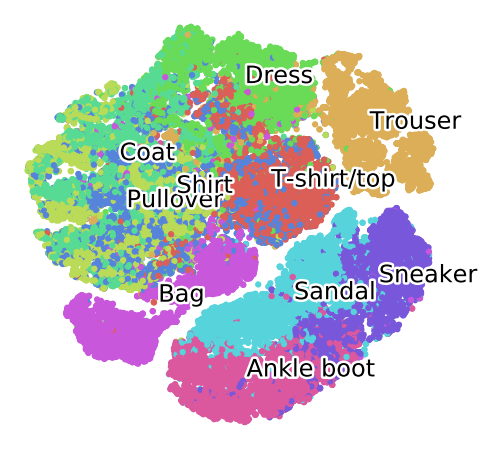

In [70]:
scatter(X_pca_tsne, Y)

График несильно отличается от предыдущего. Но при этом вычисления происходят быстрее. Без PCA у меня вычисления заняли больше часа. Если же предварительно уменьшить размерность с помощью PCA до 155 компонент, то вычисления занимают минут 20.

Сравним t-SNE с PCA. Для этого выделим 2 главные компоненты и посторим график.

In [72]:
X_pca2 = pca.transform(X)[:,:2]
X_pca2.shape

(60000, 2)

(<Figure size 576x576 with 1 Axes>,
 [Text(3.244728467044433, -2.717997996080818, 'T-shirt/top'),
  Text(0.09118882546510704, -5.595244184951341, 'Trouser'),
  Text(4.16219960451158, 1.4283481779467577, 'Pullover'),
  Text(1.2233546815286884, -4.367045715632692, 'Dress'),
  Text(4.870581051552331, 1.1507188161671884, 'Coat'),
  Text(-6.230273467339888, 0.28054742081768125, 'Sandal'),
  Text(2.627800677972143, -0.22420471668083777, 'Shirt'),
  Text(-5.967099861809021, 1.3632411082869926, 'Sneaker'),
  Text(0.1424416178230545, 3.866539488556583, 'Bag'),
  Text(-2.4783137588431936, 4.5333668513258445, 'Ankle boot')])

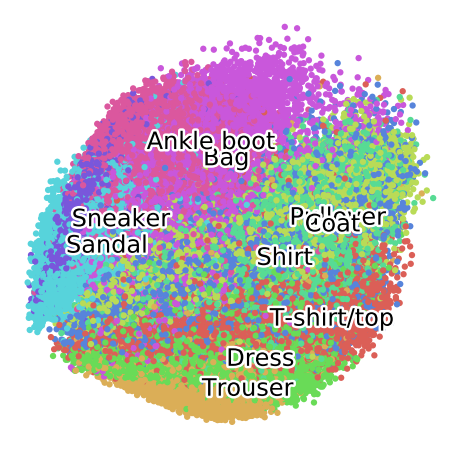

In [74]:
scatter(X_pca2, Y)

Очевидно, что PCA справился хуже t-SNE.

### 7. Подбор ccp_alpha для дерева решений

Еще я пыталась подобрать ccp_alpha для дерева решений, но там результат получается гораздо хуже. Чтобы вычисления прошли быстрее я обучала модель на 10% от всей исходной выборки.

In [4]:
Xsample, __, Ysample, __ = train_test_split(Xtrain, Ytrain, test_size=0.9, random_state=42)

In [5]:
Xsample.shape

(4800, 784)

In [6]:
Xsample_train, Xsample_test, Ysample_train, Ysample_test = train_test_split(Xsample, Ysample, test_size=0.2, random_state=42)

In [21]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(Xsample_train, Ysample_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [22]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(Xsample_train, Ysample_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07354698352269573


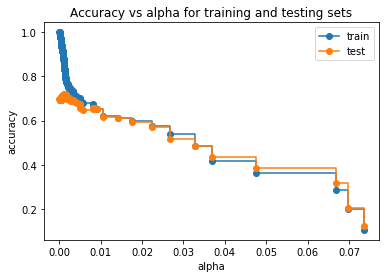

In [23]:
train_scores = [clf.score(Xsample_train, Ysample_train) for clf in clfs]
test_scores = [clf.score(Xsample_test, Ysample_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### 8. Выводы
Лучший результат показал CatBoost (0.90900 и 0.89728 в public и private лидербордах соответственно).

Снижение размерности не всегда улучшает результат. Для KNN применение PCA привело к небольшому улучшению точности. Для других же методов точность немного упала.

Метод t-SNE хорошо отделил классы брюки и сумки от других классов.

Использование t-SNE лучше проводить на предварительно сниженных размерностях с помощью PCA.